<a href="https://colab.research.google.com/github/suchith1012/Mitosis-detection-based-on-features-from-breast-cancer-histology-slide-images/blob/main/Code/Thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introdution 

In this article we are going to extract the features from the images and use optimizer technique and classifer to classify the Mitosis and Non Mitosis

Extracting data from zip file

In [ ]:
!unzip "/content/MandNM.zip" -d "/content"

Installing Libraries

In [ ]:
!git clone https://github.com/thuijskens/scikit-hyperband.git 2>/dev/null 1>/dev/null
!cp -r scikit-hyperband/* .
!python setup.py install 2>/dev/null 1>/dev/null
!pip install scikit-optimize
!pip install sklearn-deap
!pip install tpot


In [3]:
import matplotlib.pyplot as plt
from skimage import io,filters
import cv2
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
import csv
import numpy as np
import os
from google.colab.patches import cv2_imshow
from os import path
from skimage.feature import hog,ORB, CENSURE, corner_peaks, corner_harris, BRIEF
from skimage import data, color, exposure
from PIL import Image
from skimage.io import imread, imshow
from skimage.transform import resize
from sklearn.preprocessing import MinMaxScaler

from skimage.util import img_as_ubyte
import pandas as pd
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from sklearn import svm
import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from scipy.stats import randint as sp_randint
from random import randrange as sp_randrange
from sklearn.model_selection import RandomizedSearchCV
from hyperband import HyperbandSearchCV
from skopt import Optimizer
from skopt import BayesSearchCV 
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
from evolutionary_search import EvolutionaryAlgorithmSearchCV
from tpot import TPOTClassifier



In [4]:
def normalize(data):
  x = data.values 
  min_max_scaler = preprocessing.MinMaxScaler()
  x_scaled = min_max_scaler.fit_transform(x)
  df = pd.DataFrame(x_scaled)
  return df

## PCA 


In [5]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE 
from sklearn.manifold import Isomap

def pca_reduction(data,n):
  pca = PCA(n_components=n)
  reduced_features = pca.fit_transform(data)
  features = reduced_features.tolist()
  return features

In [6]:
def ptoa(data):
  df = pd.DataFrame(data)
  df = df.astype(np.float32)
  df=df.replace(np.nan, 0)
  temp=df.to_numpy()
  return temp


## edge extract

In [7]:
def edgeExtract(img, bins):
    retVal = []
    #apply vertical and horizontal sobel filters to get two histogramms, once of vertical and once of horizontal edges
    #vertical
    fs = filters.sobel_v(img)
    #horizontal
    angs = filters.sobel_h(img)
    #compute histograms
    lhist = np.histogram(fs,bins,normed=True,range=(0,1))
    ahist = np.histogram(angs, bins,normed=True,range=(-180,180))
    #fuse histograms into one list
    retVal.extend(lhist[0].tolist())
    retVal.extend(ahist[0].tolist())
    return retVal

## GridSearch

In [8]:
def grid_search(x,y):
  x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=42,stratify=y)
  result=[]
  print('Splitted Successfully')
  def classify_svm(x_train,x_test,y_train,y_test):
    param_grid={'C':[0.1,1,10,100],'gamma':[0.0001,0.001,0.1,1],'kernel':['rbf','poly','linear','sigmoid']}
    svc=svm.SVC(probability=True)
    model=GridSearchCV(svc,param_grid)
    model.fit(x_train,y_train)
    print('The svm Model is trained well with the given images',model.best_params_)
    y_pred=model.predict(x_test)
    result.append("svm:"+str(accuracy_score(y_pred,y_test)*100))
  def classify_rf(x_train,x_test,y_train,y_test):
    rfc=RandomForestClassifier(random_state=42)
    param_grid = { 'n_estimators': [1,10, 100,200, 500],'max_features': ['auto', 'sqrt', 'log2'],'max_depth' : [15,20,30,50],'criterion' :['gini', 'entropy']}
    CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
    CV_rfc.fit(x_train,y_train)
    print('The rf Model is trained well with the given images',CV_rfc.best_params_)
    y_rf_pred=CV_rfc.predict(x_test)
    result.append("Random forest:"+str(accuracy_score(y_rf_pred,y_test)*100))
  def classify_knn(x_train,x_test,y_train,y_test):
    rf_params = {'n_neighbors': [2, 3, 5,10,15,20]}
    clf = KNeighborsClassifier()
    grid = GridSearchCV(clf, rf_params, cv=3, scoring='accuracy')
    grid.fit(x_train, y_train)
    print("The KNN Model is trained well with the given images",grid.best_params_)
    result.append("KNN:"+str(grid.best_score_))
  classify_rf(x_train,x_test,y_train,y_test)
  classify_knn(x_train,x_test,y_train,y_test)
  classify_svm(x_train,x_test,y_train,y_test)
  return result







## Random Search optmizer

In [9]:
def random_search(x,y):
  x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=42,stratify=y)
  result=[]
  print('Splitted Successfully')
  def classify_rso_svm(x_train,x_test,y_train,y_test):
    rf_params = {'C': stats.uniform(0,50),"kernel":['linear','poly','rbf','sigmoid']}
    n_iter_search=20
    clf = svm.SVC(gamma='scale')
    Random_svm = RandomizedSearchCV(clf, param_distributions=rf_params,n_iter=n_iter_search,cv=3,scoring='accuracy')
    Random_svm.fit(x_train, y_train)
    print("The svm Model is trained well with the given images",Random_svm.best_params_)
    result.append("svm:"+str(Random_svm.best_score_))
  def classify_rso_rf(x_train,x_test,y_train,y_test):
    rf_params = {'n_estimators': sp_randint(10,100),"max_features":sp_randint(1,64),'max_depth': sp_randint(5,50),"min_samples_split":sp_randint(2,11),"min_samples_leaf":sp_randint(1,11),"criterion":['gini','entropy']}
    n_iter_search=20 
    clf_rf = RandomForestClassifier(random_state=0)
    Random_rf = RandomizedSearchCV(clf_rf, param_distributions=rf_params,n_iter=n_iter_search,cv=3,scoring='accuracy')
    Random_rf.fit(x_train, y_train)
    print("The rf Model is trained well with the given images",Random_rf.best_params_)
    result.append("Random forest:"+str(Random_rf.best_score_))
  def classify_rso_knn(x_train,x_test,y_train,y_test):
    rf_params = {'n_neighbors': range(1,20)}
    n_iter_search=10
    clf_knn = KNeighborsClassifier()
    Random_knn = RandomizedSearchCV(clf_knn, param_distributions=rf_params,n_iter=n_iter_search,cv=3,scoring='accuracy')
    Random_knn.fit(x_train, y_train)
    print("The KNN Model is trained well with the given images",Random_knn.best_params_)
    result.append("KNN:"+str(Random_knn.best_score_))
  classify_rso_rf(x_train,x_test,y_train,y_test)
  classify_rso_knn(x_train,x_test,y_train,y_test)
  classify_rso_svm(x_train,x_test,y_train,y_test)
  return result







## Hyperband

In [10]:
def hyperband_opt(x,y):
  x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=42,stratify=y)
  result=[]
  print('Splitted Successfully')
  def classify_hb_svm(x_train,x_test,y_train,y_test):
    rf_params = {'C': stats.uniform(0,50),"kernel":['linear','poly','rbf','sigmoid'],'bootstrap': [True, False]}
    clf_hb_svm = svm.SVC(gamma='scale')
    hyper_hb_svm = HyperbandSearchCV(clf_hb_svm, param_distributions =rf_params,cv=3,min_iter=1,max_iter=50,scoring='roc_auc',resource_param='C')
    hyper_hb_svm.fit(x_train, y_train)
    print("The svm Model is trained well with the given images",hyper_hb_svm.best_params_)
    result.append("svm:"+str(hyper_hb_svm.best_score_))
  def classify_hb_rf(x_train,x_test,y_train,y_test):
    rf_params = {'n_estimators': sp_randint(10,100),'bootstrap': [True, False],"max_features":sp_randint(1,64),'max_depth': sp_randint(5,50),"min_samples_split":sp_randint(2,11),"min_samples_leaf":sp_randint(1,11),"criterion":['gini','entropy']}
    clf_hb_rf = RandomForestClassifier(random_state=0)
    hyper_rf = HyperbandSearchCV(clf_hb_rf, param_distributions =rf_params,cv=3,min_iter=10,max_iter=100,scoring='roc_auc')
    hyper_rf.fit(x_train, y_train)
    print("The rf Model is trained well with the given images",hyper_rf.best_params_)
    result.append("Random forest:"+str(hyper_rf.best_score_))
  def classify_hb_knn(x_train,x_test,y_train,y_test):
    rf_params = {'n_neighbors': range(1,20),'bootstrap': [True, False]}
    clf_hb_knn = KNeighborsClassifier()
    hyper_knn = HyperbandSearchCV(clf_hb_knn, param_distributions =rf_params,cv=3,min_iter=1,max_iter=20,scoring='roc_auc',resource_param='n_neighbors')
    hyper_knn.fit(x_train, y_train)
    print("The KNN Model is trained well with the given images",hyper_knn.best_params_)
    result.append("KNN:"+str(hyper_knn.best_score_))
  classify_hb_rf(x_train,x_test,y_train,y_test)
  classify_hb_knn(x_train,x_test,y_train,y_test)
  classify_hb_svm(x_train,x_test,y_train,y_test)
  return result







## Bayesian Optimization with Gaussian Process (BO-GP)

In [11]:
def bogp(x,y):
  x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=42,stratify=y)
  result=[]
  print('Splitted Successfully')
  def classify_bogp_svm(x_train,x_test,y_train,y_test):
    rf_params = {'C':[0.1,1,10,100],"kernel":['linear','poly','rbf','sigmoid']}
    clf_svm = svm.SVC(gamma='scale')
    Bayes_svm = BayesSearchCV(clf_svm, rf_params,cv=3,n_iter=20, n_jobs=-1,scoring='accuracy')
    Bayes_svm.fit(x_train, y_train)
    print("The svm Model is trained well with the given images",Bayes_svm.best_params_)
    result.append("svm:"+str(Bayes_svm.best_score_))
  def classify_bogp_rf(x_train,x_test,y_train,y_test):
    rf_params = {'n_estimators': Integer(10,100),"max_features":Integer(1,64),'max_depth': Integer(5,50),"min_samples_split":Integer(2,11),"min_samples_leaf":Integer(1,11),"criterion":['gini','entropy']}
    clf_bogp_rf = RandomForestClassifier(random_state=0)
    Bayes_rf = BayesSearchCV(clf_bogp_rf, rf_params,cv=3,n_iter=20, n_jobs=-1,scoring='accuracy')
    Bayes_rf.fit(x_train, y_train)
    print("The rf Model is trained well with the given images",Bayes_rf.best_params_)
    result.append("Random forest:"+str(Bayes_rf.best_score_))
  def classify_bogp_knn(x_train,x_test,y_train,y_test):
    rf_params = {'n_neighbors': Integer(1,20)}
    clf_bogp_knn = KNeighborsClassifier()
    Bayes_knn = BayesSearchCV(clf_bogp_knn, rf_params,cv=3,n_iter=10, n_jobs=-1,scoring='accuracy')
    Bayes_knn.fit(x_train, y_train)
    print("The KNN Model is trained well with the given images",Bayes_knn.best_params_)
    result.append("KNN:"+str(Bayes_knn.best_score_))
  classify_bogp_rf(x_train,x_test,y_train,y_test)
  classify_bogp_knn(x_train,x_test,y_train,y_test)
  classify_bogp_svm(x_train,x_test,y_train,y_test)
  return result

## skopt.gp_minimize

In [12]:


def skopt_gp(x,y):
  x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=42,stratify=y)
  result=[]
  print('Splitted Successfully')
  def classify_skgp_svm(x_train,x_test,y_train,y_test):
    reg = svm.SVC(gamma='scale')
    space  = [Real(0.01, 50, name='C'),Categorical(['linear','poly','rbf','sigmoid'], name='kernel')]
    @use_named_args(space)
    def objective(**params):
      reg.set_params(**params)
      return -np.mean(cross_val_score(reg, x_train, y_train, cv=3, n_jobs=-1,scoring="accuracy"))
    res_svm = gp_minimize(objective, space, n_calls=20, random_state=0)
    # print("The svm Model is trained well with the given images",Bayes_svm.best_params_)
    result.append("svm:"+str(-res_svm.fun))
  def classify_skgp_rf(x_train,x_test,y_train,y_test):
    reg = RandomForestClassifier()
    space  = [Integer(10, 100, name='n_estimators'),Integer(5, 50, name='max_depth'),Integer(1, 64, name='max_features'),Integer(2, 11, name='min_samples_split'),Integer(1, 11, name='min_samples_leaf'),Categorical(['gini', 'entropy'], name='criterion'),]
    @use_named_args(space)
    def objective(**params):
      reg.set_params(**params)
      return -np.mean(cross_val_score(reg, x_train, y_train, cv=3, n_jobs=-1,scoring="accuracy"))
    res_gp = gp_minimize(objective, space, n_calls=20, random_state=0)
    result.append("Random forest:"+str(-res_gp.fun))
  def classify_skgp_knn(x_train,x_test,y_train,y_test):
    reg = KNeighborsClassifier()
    space  = [Integer(1, 20, name='n_neighbors')]
    @use_named_args(space)
    def objective(**params):
      reg.set_params(**params)
      return -np.mean(cross_val_score(reg, x_train, y_train, cv=3, n_jobs=-1,scoring="accuracy"))
    res_knn = gp_minimize(objective, space, n_calls=10, random_state=0)
    # print("The KNN Model is trained well with the given images",Bayes_knn.best_params_)
    result.append("KNN:"+str(-res_knn.fun))
  classify_skgp_rf(x_train,x_test,y_train,y_test)
  classify_skgp_knn(x_train,x_test,y_train,y_test)
  classify_skgp_svm(x_train,x_test,y_train,y_test)
  return result

## Bayesian Optimization with Tree-structured Parzen Estimator (TPE)

In [13]:
def bo_tpe(x,y):
  x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=42,stratify=y)
  result=[]
  print('Splitted Successfully')
  def classify_botpe_svm(x_train,x_test,y_train,y_test):
    def objective(params):
      params = {'C': abs(float(params['C'])), "kernel":str(params['kernel'])}
      clf = svm.SVC(gamma='scale', **params)
      score = cross_val_score(clf, x_train, y_train, scoring='accuracy', cv=StratifiedKFold(n_splits=3)).mean()
      return {'loss':-score, 'status': STATUS_OK }
    space = {'C': hp.normal('C', 0, 50),"kernel":hp.choice('kernel',['linear','poly','rbf','sigmoid'])}
    best_svm = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
    result.append("svm:"+str(best_svm))
  def classify_botpe_rf(x_train,x_test,y_train,y_test):
    def objective(params):
      params = {'n_estimators': int(params['n_estimators']), 'max_depth': int(params['max_depth']),'max_features': int(params['max_features']),"min_samples_split":int(params['min_samples_split']),"min_samples_leaf":int(params['min_samples_leaf']),"criterion":str(params['criterion'])}
      clf = RandomForestClassifier( **params)
      score = cross_val_score(clf, x_train, y_train, scoring='accuracy', cv=StratifiedKFold(n_splits=3)).mean()
      return {'loss':-score, 'status': STATUS_OK }
    space = {'n_estimators': hp.quniform('n_estimators', 10, 100, 1),'max_depth': hp.quniform('max_depth', 5, 50, 1),"max_features":hp.quniform('max_features', 1, 64, 1),"min_samples_split":hp.quniform('min_samples_split',2,11,1),"min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),"criterion":hp.choice('criterion',['gini','entropy'])}
    best_rf = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
    result.append("Random forest:"+str(best_rf))
  def classify_botpe_knn(x_train,x_test,y_train,y_test):
    def objective(params):
      params = {'n_neighbors': abs(int(params['n_neighbors']))}
      clf = KNeighborsClassifier( **params)
      score = cross_val_score(clf, x_train, y_train, scoring='accuracy', cv=StratifiedKFold(n_splits=3)).mean()
      return {'loss':-score, 'status': STATUS_OK }
    space = {'n_neighbors': hp.quniform('n_neighbors', 1, 20, 1),}
    best_knn = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)
    result.append("KNN:"+str(best_knn))
  classify_botpe_rf(x_train,x_test,y_train,y_test)
  classify_botpe_knn(x_train,x_test,y_train,y_test)
  classify_botpe_svm(x_train,x_test,y_train,y_test)
  return result

## Genetic Algorithm

In [14]:
def genetic(x,y):
  x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=42,stratify=y)
  result=[]
  print('Splitted Successfully')
  def classify_g_svm(x_train,x_test,y_train,y_test):
    rf_params = {'C': np.random.uniform(0,50,1000),"kernel":['linear','poly','rbf','sigmoid']}
    clf_g_svm = svm.SVC(gamma='scale')
    ga1_svm = EvolutionaryAlgorithmSearchCV(estimator=clf_g_svm,
                                   params=rf_params,
                                   scoring="accuracy",
                                   cv=3,
                                   verbose=1,
                                   population_size=10,
                                   gene_mutation_prob=0.10,
                                   gene_crossover_prob=0.5,
                                   tournament_size=3,
                                   generations_number=5,
                                   n_jobs=1)
    ga1_svm.fit(x_train, y_train)
    print('The rf Model is trained well with the given images',ga1_svm.best_params_)
    result.append("svm:"+str(ga1_svm.best_score_))
  def classify_g_rf(x_train,x_test,y_train,y_test):
    rf_params = {'n_estimators': np.logspace(1,1.8,num = 10 ,base=20,dtype='int'),'max_depth': np.logspace(1,2,num = 10 ,base=10,dtype='int'),"max_features":np.logspace(0.2,1,num = 5 ,base=8,dtype='int'),"min_samples_split":np.logspace(0.4, 1, num=5, base=10, dtype='int'),"min_samples_leaf":np.logspace(0.1,1,num = 5 ,base=11,dtype='int'),"criterion":['gini','entropy']}
    rf_params = {'n_estimators': range(10,100),"max_features":range(1,64),'max_depth': range(5,50),"min_samples_split":range(2,11),"min_samples_leaf":range(1,11),"criterion":['gini','entropy']}
    clf_g_rf = RandomForestClassifier(random_state=0)
    ga1_rf = EvolutionaryAlgorithmSearchCV(estimator=clf_g_rf,
                                   params=rf_params,
                                   scoring="accuracy",
                                   cv=3,
                                   verbose=1,
                                   population_size=10,
                                   gene_mutation_prob=0.10,
                                   gene_crossover_prob=0.5,
                                   tournament_size=3,
                                   generations_number=5,
                                   n_jobs=1)
    ga1_rf.fit(x_train, y_train)
    print('The rf Model is trained well with the given images',ga1_rf.best_params_)
    result.append("Random forest:"+str(ga1_rf.best_score_))
  def classify_g_knn(x_train,x_test,y_train,y_test):
    rf_params = {'n_neighbors': range(1,20),}
    clf_g_knn = KNeighborsClassifier()
    ga1_knn = EvolutionaryAlgorithmSearchCV(estimator=clf_g_knn,
                                   params=rf_params,
                                   scoring="accuracy",
                                   cv=3,
                                   verbose=1,
                                   population_size=10,
                                   gene_mutation_prob=0.10,
                                   gene_crossover_prob=0.5,
                                   tournament_size=3,
                                   generations_number=5,
                                   n_jobs=1)
    ga1_knn.fit(x_train, y_train)
    print('The knn Model is trained well with the given images',ga1_knn.best_params_)
    result.append("KNN:"+str(ga1_knn.best_score_))
  classify_g_rf(x_train,x_test,y_train,y_test)
  classify_g_knn(x_train,x_test,y_train,y_test)
  classify_g_svm(x_train,x_test,y_train,y_test)
  return result

## TPOT

In [15]:
def tpot(x,y):
  x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=42,stratify=y)
  result=[]
  print('Splitted Successfully')
  def classify_tpot_svm(x_train,x_test,y_train,y_test):
    parameters = {'C': np.random.uniform(0,50,1000),"kernel":['linear','poly','rbf','sigmoid']}
    ga2_svm = TPOTClassifier(generations= 3, population_size= 10, offspring_size= 5,
                                 verbosity= 3, early_stop= 5,
                                 config_dict=
                                 {'sklearn.svm.SVC': parameters}, 
                                 cv = 3, scoring = 'accuracy')
    ga2_svm.fit(x_train, y_train)
    y_rf_pred=ga2_svm.predict(x_test)
    result.append("svm:"+str(accuracy_score(y_rf_pred,y_test)*100))
  def classify_tpot_rf(x_train,x_test,y_train,y_test):
    parameters = {'n_estimators': range(20,200),"max_features":range(1,64),'max_depth': range(10,100),"min_samples_split":range(2,11),"min_samples_leaf":range(1,11),"criterion":['gini','entropy']}
    ga2_rf = TPOTClassifier(generations= 3, population_size= 10, offspring_size= 5,
                                 verbosity= 3, early_stop= 5,
                                 config_dict=
                                 {'sklearn.ensemble.RandomForestClassifier': parameters}, 
                                 cv = 3, scoring = 'accuracy')
    ga2_rf.fit(x_train, y_train)
    y_rf_pred=ga2_rf.predict(x_test)
    result.append("Random forest:"+str(accuracy_score(y_rf_pred,y_test)*100))
  def classify_tpot_knn(x_train,x_test,y_train,y_test):
    parameters = {'n_neighbors': range(1,20),}
    ga2_knn = TPOTClassifier(generations= 3, population_size= 10, offspring_size= 5,
                                 verbosity= 3, early_stop= 5,
                                 config_dict=
                                 {'sklearn.neighbors.KNeighborsClassifier': parameters}, 
                                 cv = 3, scoring = 'accuracy')
    ga2_knn.fit(x_train, y_train)
    y_rf_pred=ga2_knn.predict(x_test)
    result.append("knn:"+str(accuracy_score(y_rf_pred,y_test)*100))
  classify_tpot_rf(x_train,x_test,y_train,y_test)
  classify_tpot_knn(x_train,x_test,y_train,y_test)
  classify_tpot_svm(x_train,x_test,y_train,y_test)
  return result

## Histogram of Oriented Gradients(HOG) 


*   HOG descriptor focuses on the structure or the shape of an object
*   HOG would generate a Histogram for each  regions separately. The histograms are created using the gradients and orientations of the pixel values, hence the name ‘Histogram of Oriented Gradients’

### Extracting hog features

[0.13967154 0.07405471 0.00404335 ... 0.0584853  0.0459223  0.03301468]


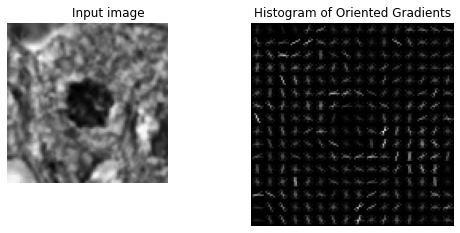

In [16]:
img = io.imread(r"/content/MandNM/mitosis/A00_01_01_CZ8UV4CK9-1a2574be1ed31c6659b0878de25f8c97.png")

image = color.rgb2gray(img)

resized = cv2.resize(image, (128, 128), interpolation=cv2.INTER_AREA)
fd, hog_image = hog(resized,visualize=True)
print(fd)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')
ax1.set_adjustable('box')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
ax1.set_adjustable('box')
plt.show()

(15876,)


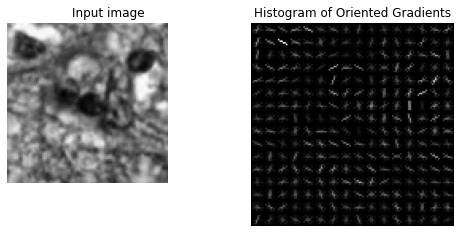

In [17]:
img = io.imread(r"/content/MandNM/nonmitosis/A00_01_01_VX9XQ1HO9-c9862dc6a1df71ff47c2f543a819cffe.png")

image = color.rgb2gray(img)

resized = cv2.resize(image, (128, 128), interpolation=cv2.INTER_AREA)
fd, hog_image = hog(resized,visualize=True)
print(fd.shape)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')
ax1.set_adjustable('box')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
ax1.set_adjustable('box')
plt.show()

In [18]:
category = []
hogArray = []
for folder in os.listdir("/content/MandNM/"):

    if(folder == ".DS_Store"):
        continue

    # Loop through each category
    for filename in os.listdir(path.join("/content/MandNM", folder)):

        # Select images which are png and jpg only
        if (filename[-3:] == "png" or filename[-3:] == "jpg"):

            # Get full image by joining
            # all the path to the image
            image = path.join("MandNM", folder, filename)

            # Use open cv to read the image
            img = cv2.imread(image)
            image_grey = color.rgb2gray(img)

            # Resize the image to (64, 128)
            # Default for hog
            resized = cv2.resize(image_grey, (128, 128), interpolation=cv2.INTER_AREA)

            # Compute the Hog Features
            fd, hog_image = hog(resized,visualize=True)
            
            category.append(folder)
            hogArray.append(fd)



# convert the extracted features
# from array to vector
hogArray_np = np.array(hogArray)


print("Total feature extracted from the each image",len(hogArray_np[0]))

Total feature extracted from the each image 15876


In [19]:
hog_features=pca_reduction(hogArray_np,400)

In [20]:
csvData = []
for id, line in enumerate(hog_features):
  if(id==0):
    temp=[]
    for i in range(0,len(line)):
      temp.append("value"+str(i))
    temp.insert(len(temp),"label")
    csvData.append(temp)

  newImg = line

    # Prepend the category of each image to
    # the begining of the features
  newImg.insert(len(newImg), category[id])
  csvData.append(newImg)


# Save the csv file
with open('result_hog_data.csv', 'w') as csvFile:
    writer = csv.writer(csvFile)
    writer.writerows(csvData)

csvFile.close()

print("Done Extracting Features")

Done Extracting Features


In [21]:
import pandas as pd

feature_hog=pd.read_csv("result_hog_data.csv")
feature_hog['label'] = feature_hog['label'].map({'nonmitosis': 1, 'mitosis': 0})
feature_hog

,value0,value1,value2,value3,value4,value5,value6,value7,value8,value9,value10,value11,value12,value13,value14,value15,value16,value17,value18,value19,value20,value21,value22,value23,value24,value25,value26,value27,value28,value29,value30,value31,value32,value33,value34,value35,value36,value37,value38,value39,...,value361,value362,value363,value364,value365,value366,value367,value368,value369,value370,value371,value372,value373,value374,value375,value376,value377,value378,value379,value380,value381,value382,value383,value384,value385,value386,value387,value388,value389,value390,value391,value392,value393,value394,value395,value396,value397,value398,value399,label
0,-1.350751,0.744063,2.828002,1.488705,0.604587,0.198014,-0.088769,-0.586226,-0.196583,-0.338038,0.970625,0.524208,0.312863,-0.274286,-0.399208,0.339142,0.356670,-0.434151,0.363181,-0.653040,-0.532412,-0.297976,0.393039,-0.835502,-0.433321,-0.206350,-0.359925,0.296738,-0.591952,0.402581,-0.563544,0.052543,-0.609162,-0.525276,0.293777,-0.064934,-0.366792,-0.393081,-0.163280,-0.289432,...,0.449290,0.294645,0.209454,-0.249307,-0.412970,0.361566,-0.360394,-0.539425,0.169341,0.243024,0.034407,0.010570,-0.233500,-0.089682,-0.330753,0.077658,0.311313,-0.025462,0.177129,-0.241393,0.057935,0.279088,0.488415,0.346175,-0.378293,0.339962,-0.377706,-0.332571,0.003888,0.307733,-0.323010,0.303982,0.098325,0.110583,-0.031710,0.170912,-0.365128,-0.229743,0.604013,0
1,-0.145677,-0.766594,0.868124,-1.994485,-0.357343,0.653924,-0.185722,0.559986,-0.697626,0.829572,-0.918668,-0.602372,0.921835,-1.104932,-0.067057,-0.156607,-0.912433,-0.080461,-0.768110,0.145694,0.620949,0.630911,0.080516,-0.129331,1.195345,-0.079360,-0.798757,-0.968560,-0.140586,-0.065083,0.179707,0.848040,-0.136162,-0.424545,-1.058376,-0.716689,0.388147,-1.045487,-0.589609,0.284796,...,0.087354,0.060110,-0.227990,-0.273586,-0.378818,0.280337,-0.302796,-0.415930,-0.437068,-0.346682,0.289178,-0.202056,0.456190,0.417255,-0.048425,0.319123,-0.161744,0.421353,-0.084555,-0.049576,-0.127595,-0.076043,0.102012,-0.067711,0.125893,-0.139379,0.056495,0.107646,0.361974,-0.356463,0.248548,0.117655,0.325944,0.203666,-0.036938,-0.086525,0.332470,0.002051,0.166763,0
2,-1.506520,0.133689,0.615612,-0.034797,1.117373,0.180478,1.477343,-0.143741,0.282394,-0.112341,-0.404270,1.143333,0.124674,0.009698,-0.261090,-0.664126,-0.790516,0.097044,-1.086370,-0.253277,-0.321761,-0.338633,1.144745,1.994019,-0.570015,0.508359,-0.086749,-1.072047,-0.258218,-0.111115,-0.274512,0.658529,1.173801,-0.611660,-0.202915,1.098538,0.289396,-0.402164,0.136126,0.040257,...,0.002504,-0.013545,0.204892,-0.028558,0.223099,0.148055,-0.238922,0.244619,-0.064852,-0.624825,0.249051,0.009557,-0.301638,0.152595,-0.313691,0.119189,0.257881,0.812025,0.044484,-0.042798,-0.325409,-0.234459,0.352910,-0.171690,0.134701,-0.256154,-0.054273,0.023901,0.004438,-0.170234,-0.402579,0.022797,-0.064945,0.023058,-0.221447,-0.138060,0.481968,0.017800,-0.062694,0
3,-0.199565,0.465821,-0.423813,-0.461612,-0.213157,0.967217,-0.761422,0.813642,-1.333668,0.504284,0.772371,-0.917347,-0.472559,-0.293107,0.305704,0.269421,-0.452343,0.415729,-0.029141,-0.360837,0.610903,-0.138663,0.124914,0.005689,-0.152032,-0.305016,-0.683944,0.332609,-0.901827,0.042654,0.026320,1.192160,0.225958,-0.302983,-0.005127,-0.064549,-0.064427,-0.048352,0.215616,-0.215420,...,-0.077201,0.339348,-0.472234,0.155843,0.188377,-0.284743,-0.082716,-0.142133,0.063954,0.189193,-0.015459,0.087158,-0.029749,0.214540,-0.239113,0.131976,-0.071619,0.290474,-0.242473,0.337163,0.165269,0.334266,0.076955,0.197658,0.077430,-0.127593,0.197500,-0.153443,-0.219862,-0.157447,0.289457,-0.147914,0.009872,0.255366,0.172224,-0.009248,-0.318675,-0.031802,-0.206135,0
4,0.558966,-0.156577,0.162601,-0.740416,-0.197055,-0.523983,-0.546396,-1.123024,-0.565070,-0.247203,-0.054153,0.049199,0.658564,0.728309,-0.534389,0.852255,-1.075244,-0.803030,0.502114,-0.256546,0.377753,0.534239,-0.371512,-0.122626,0.010771,0.764454,-0.154147,-0.639467,0.580875,0.634

### classification based on features

In [22]:
print("results for gridsearch:")
grid_search(feature_hog.iloc[:,:-1],feature_hog.iloc[:,-1])

results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'gini', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 500}
The KNN Model is trained well with the given images {'n_neighbors': 5}
The svm Model is trained well with the given images {'C': 10, 'gamma': 0.001, 'kernel': 'sigmoid'}


['Random forest:77.01149425287356',
 'KNN:0.5681159420289855',
 'svm:86.20689655172413']

In [23]:
print("results for random search")
random_search(feature_hog.iloc[:,:-1],feature_hog.iloc[:,-1])

results for random search
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'gini', 'max_depth': 47, 'max_features': 46, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 95}
The KNN Model is trained well with the given images {'n_neighbors': 5}
The svm Model is trained well with the given images {'C': 21.443698558361906, 'kernel': 'rbf'}


['Random forest:0.7246376811594203',
 'KNN:0.5681159420289855',
 'svm:0.8347826086956521']

In [24]:
# print("results for hyperband")
# hyperband_opt(feature_hog.iloc[:,:-1],feature_hog.iloc[:,-1])

In [25]:
print("results for Bayesian Optimization with Gaussian Process (BO-GP)")
bogp(feature_hog.iloc[:,:-1],feature_hog.iloc[:,-1])

results for Bayesian Optimization with Gaussian Process (BO-GP)
Splitted Successfully
The rf Model is trained well with the given images OrderedDict([('criterion', 'gini'), ('max_depth', 15), ('max_features', 36), ('min_samples_leaf', 3), ('min_samples_split', 4), ('n_estimators', 100)])
The KNN Model is trained well with the given images OrderedDict([('n_neighbors', 3)])
The svm Model is trained well with the given images OrderedDict([('C', 1.0), ('kernel', 'rbf')])


['Random forest:0.6956521739130435',
 'KNN:0.5623188405797102',
 'svm:0.8434782608695652']

In [26]:
print("results for skopt")
skopt_gp(feature_hog.iloc[:,:-1],feature_hog.iloc[:,-1])

results for skopt
Splitted Successfully


['Random forest:0.7014492753623189',
 'KNN:0.5565217391304348',
 'svm:0.8347826086956521']

In [27]:
print("result for bo_tpe")
bo_tpe(feature_hog.iloc[:,:-1],feature_hog.iloc[:,-1])

result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:01<00:00, 12.53it/s, best loss: -0.8347826086956521]


["Random forest:{'criterion': 1, 'max_depth': 20.0, 'max_features': 42.0, 'min_samples_leaf': 3.0, 'min_samples_split': 9.0, 'n_estimators': 93.0}",
 "KNN:{'n_neighbors': 13.0}",
 "svm:{'C': 77.14129151190534, 'kernel': 2}"]

In [28]:
print("result for genetic")
genetic(feature_hog.iloc[:,:-1],feature_hog.iloc[:,-1])

result for genetic
Splitted Successfully
Types [1, 1, 1, 1, 1, 1] and maxint [89, 62, 44, 8, 9, 1] detected
--- Evolve in 45927000 possible combinations ---
gen	nevals	avg     	min     	max     	std      
0  	10    	0.611594	0.542029	0.689855	0.0478217
1  	5     	0.650435	0.585507	0.689855	0.0355046
2  	5     	0.683478	0.626087	0.689855	0.0191304
3  	5     	0.684928	0.64058 	0.689855	0.0147826
4  	6     	0.684928	0.64058 	0.689855	0.0147826
5  	3     	0.690435	0.689855	0.695652	0.00173913
Best individual is: {'n_estimators': 77, 'max_features': 53, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 10, 'criterion': 'entropy'}
with fitness: 0.6956521739130435
The rf Model is trained well with the given images {'n_estimators': 77, 'max_features': 53, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 10, 'criterion': 'entropy'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std       
0  	10    	0.541449	0.527536	0.556522	0.00959591
1  	8     	0.548116	0.533333	0.556522	0.00824433
2  	3     	0.552754	0.542029	0.556522	0.00550725
3  	8     	0.556522	0.556522	0.556522	1.11022e-16
4  	10    	0.556522	0.556522	0.556522	1.11022e-16
5  	6     	0.551884	0.527536	0.556522	0.00963087 
Best individual is: {'n_neighbors': 13}
with fitness: 0.5565217391304348
The knn Model is trained well with the given images {'n_neighbors': 13}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std     
0  	10    	0.691304	0.498551	0.834783	0.130378
1  	10    	0.76058 	0.498551	0.834783	0.0954429
2  	4     	0.834783	0.834783	0.834783	0        
3  	5     	0.834783	0.834783	0.834783	0        
4  	6     	0.834783	0.834783	0.834783	0        
5  	6     	0.834783	0.834783	0.834783	0        
Best individual is: {'C': 30.812551660580702, 'kernel': 'rbf'}
with fitness: 0.8347826086956521
The rf Model is trained well with the given images {'C': 30.812551660580702, 'kernel': 'rbf'}


['Random forest:0.6956521739130435',
 'KNN:0.5565217391304348',
 'svm:0.8347826086956521']

In [29]:
print("result for tpot")
tpot(feature_hog.iloc[:,:-1],feature_hog.iloc[:,-1])

result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7101449275362318	RandomForestClassifier(CombineDFs(input_matrix, input_matrix), RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=68, RandomForestClassifier__max_features=27, RandomForestClassifier__min_samples_leaf=1, RandomForestClassifier__min_samples_split=7, RandomForestClassifier__n_estimators=189)

Generation 2 - Current Pareto front scores:

-1	0.7130434782608696	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=90, RandomForestClassifier__max_features=42, RandomForestClassifier__min_samples_leaf=4, RandomForestClassifier__min_samples_split=10, RandomForestClassifier__n_estimators=141)

Generation 3 - Current Pareto front scores:

-1	0.7217391304347828	RandomForestClassifier(CombineDFs(input_matrix, input_matrix), RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=43, RandomForestClassifier__max_features=58, RandomF

Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]

Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 1 - Current Pareto front scores:

-1	0.5681159420289855	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=5)

-2	0.5855072463768116	KNeighborsClassifier(KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=1), KNeighborsClassifier__n_neighbors=9)

Generation 2 - Current Pareto front scores:

-1	0.5681159420289855	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=5)

-2	0.5855072463768116	KNeighborsClassifier(KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=1), KNeighborsClassifier__n_neighbors=9)

Generation 3 - Current Pareto front scores:

-1	0.5681159420289855	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=5)

-2	0.5855072463768116	KNeighborsClassifier(KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=1), KNeighborsClassifier

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7565217391304349	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=31.623248052239834, SVC__kernel=linear)

Generation 2 - Current Pareto front scores:

-1	0.7565217391304349	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=31.623248052239834, SVC__kernel=linear)

Generation 3 - Current Pareto front scores:

-1	0.7565217391304349	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=31.623248052239834, SVC__kernel=linear)


['Random forest:77.01149425287356',
 'knn:66.66666666666666',
 'svm:78.16091954022988']

## ORB(Oriented FAST and Rotated BRIEF)
ORB is an efficient open source alternative to SIFT and SURF. Even though it computes less key points when compared to SIFT and SURF yet they are effective. It uses FAST and BRIEF techniques to detect the key points and compute the image descriptors respectively.

### Extracting orb features

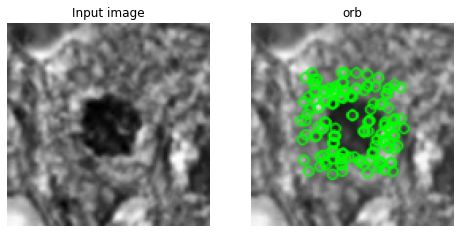

In [30]:
img = io.imread(r"/content/MandNM/mitosis/A00_01_01_CZ8UV4CK9-1a2574be1ed31c6659b0878de25f8c97.png", as_gray=True)

resized = resize(img, (128, 128))
img3 = img_as_ubyte(resized)


orb = cv2.ORB_create(nfeatures=2000)
kp, des = orb.detectAndCompute(img3, None)

kp_img = cv2.drawKeypoints(img3, kp, None, color=(0, 255, 0), flags=0)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(resized, cmap=plt.cm.gray)
ax1.set_title('Input image')
ax1.set_adjustable('box')
# hog_image_rescaled = exposure.rescale_intensity(img2, in_range=(0, 10))
ax2.axis('off')
ax2.imshow(kp_img, cmap=plt.cm.gray)
ax2.set_title('orb')
ax1.set_adjustable('box')
plt.show()

In [31]:
category_orb = []
Array_orb = []
for folder in os.listdir("/content/MandNM/"):

    if(folder == ".DS_Store"):
        continue

    # Loop through each category
    for filename in os.listdir(path.join("/content/MandNM", folder)):

        # Select images which are png and jpg only
        if (filename[-3:] == "png" or filename[-3:] == "jpg"):

            # Get full image by joining
            # all the path to the image
            image = path.join("MandNM", folder, filename)

            # Use open cv to read the image
            img = io.imread(image, as_gray=True)
            resized = resize(img, (128, 128))
            img3 = img_as_ubyte(resized)
            orb = cv2.ORB_create(nfeatures=2000)
            kp, des = orb.detectAndCompute(img3, None)
            x_image_features = np.vstack(np.array(des))
            scaler = MinMaxScaler(feature_range=(0,1))
            x_image_scaled = scaler.fit_transform(x_image_features)
            
            category_orb.append(folder)
            Array_orb.append(x_image_scaled.flatten())



# convert the extracted features
# from array to vector
orbArray_np = np.array(Array_orb)


print("Total feature extracted from the each image",len(orbArray_np[0]))

Total feature extracted from the each image 4992


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [32]:
temp=ptoa(Array_orb)
orb_features=pca_reduction(temp,400)

In [33]:
csvData = []
for id, line in enumerate(orb_features):
  if(id==0):
    temp=[]
    for i in range(0,len(line)):
      temp.append("value"+str(i))
    temp.insert(len(temp),"label")
    csvData.append(temp)

  newImg = line

    # Prepend the category of each image to
    # the begining of the features
  newImg.insert(len(newImg), category[id])
  csvData.append(newImg)


# Save the csv file
with open('result_orb_data.csv', 'w') as csvFile:
    writer = csv.writer(csvFile)
    writer.writerows(csvData)

csvFile.close()

print("Done Extracting Features")

Done Extracting Features


In [34]:
import pandas as pd

feature_orb=pd.read_csv("result_orb_data.csv")
feature_orb['label'] = feature_orb['label'].map({'nonmitosis': 1, 'mitosis': 0})
feature_orb

,value0,value1,value2,value3,value4,value5,value6,value7,value8,value9,value10,value11,value12,value13,value14,value15,value16,value17,value18,value19,value20,value21,value22,value23,value24,value25,value26,value27,value28,value29,value30,value31,value32,value33,value34,value35,value36,value37,value38,value39,...,value361,value362,value363,value364,value365,value366,value367,value368,value369,value370,value371,value372,value373,value374,value375,value376,value377,value378,value379,value380,value381,value382,value383,value384,value385,value386,value387,value388,value389,value390,value391,value392,value393,value394,value395,value396,value397,value398,value399,label
0,0.407201,-7.351944,0.469657,3.617051,-1.148884,-2.935915,-1.744037,2.656035,1.207625,-1.859751,-0.138403,-0.064166,1.374624,0.679740,2.280681,-0.533402,-2.086235,-0.778949,0.071593,-0.469288,0.705891,0.991932,1.684276,-0.305618,-0.913018,-0.538069,-0.047594,0.204613,1.160997,0.940525,-1.359257,-0.268842,-0.029473,-1.472576,-1.871030,1.044124,0.842022,0.196959,1.146119,0.082614,...,0.410598,1.613769,-0.400097,-1.260440,-0.135615,-0.246461,-1.102957,0.774726,-0.849898,-0.803790,0.274027,0.183642,-0.172790,-0.052399,-0.125590,-0.222052,0.142590,0.558176,-0.225734,0.421376,0.137532,0.886106,-0.808130,0.588359,-0.579246,0.547040,-0.388366,-0.404155,0.156106,-0.192020,1.046978,-0.005015,0.413928,0.143813,-0.255151,0.011321,-0.775653,-0.079476,-0.244925,0
1,-12.575683,1.929293,-3.391193,-3.750606,-2.469472,0.441243,-2.298337,2.392932,-1.580753,0.880230,-0.050810,-1.976699,0.283890,1.882136,-2.011014,2.665805,-0.549200,-0.132387,-1.973207,-0.938464,-0.159833,-1.347457,-0.170453,-0.122056,-0.178757,-0.681265,-0.051932,0.799668,2.234272,0.905565,0.383591,-0.808530,0.836780,-0.228270,-0.096283,-0.126311,0.335866,0.436589,0.217573,-0.162768,...,-0.823157,-0.191488,-0.320719,-1.700835,0.560799,-0.415726,-1.573312,0.412596,-0.335746,-0.007860,0.123771,-0.239058,1.448942,0.071004,0.581753,0.267810,0.450655,2.480757,-0.751286,-0.556593,-0.396940,-0.965812,1.199171,1.364927,-0.628967,1.253050,-0.013612,-0.507908,-0.528539,0.205376,0.721529,0.265154,-0.329109,0.662515,-1.907741,1.203922,0.892173,1.468921,-0.485831,0
2,8.432089,-3.689652,4.716156,-3.265014,-1.015305,2.022722,2.967172,-1.061295,-1.216302,-0.003182,0.737115,1.015626,1.050609,0.104884,4.282742,0.382438,2.066022,2.224015,1.316238,0.802823,-0.104378,2.106814,-1.421858,0.231282,-0.548275,1.178753,1.137689,-0.810446,2.180858,1.013856,1.701939,0.797482,-0.532083,-0.741812,0.220490,-0.154150,-0.495314,-1.480121,-0.134855,0.468562,...,0.257170,-0.619126,0.252055,0.143776,-1.342950,-0.048367,0.205373,0.246060,-0.301724,-0.286136,0.141869,0.260136,0.147292,-0.417120,0.305840,-0.411824,-0.332375,0.636029,0.081644,-0.180702,0.192657,0.197761,-0.214292,0.331238,-0.265419,-0.594662,-0.300666,0.331094,0.231498,0.610555,0.634098,0.216172,0.313890,-0.405951,1.194181,0.139728,-0.164449,0.177288,0.054207,0
3,14.317125,5.615886,-0.801387,-3.424456,2.602672,-2.223054,-2.411268,-1.322103,1.408398,1.779516,-0.194592,1.135548,-0.182542,0.090735,-0.803297,2.499274,1.241023,-0.753244,-0.334421,-3.248015,-2.817431,5.130667,1.516411,1.411829,1.958441,-2.616155,2.802693,-1.683883,-1.716157,-3.197781,-0.362304,-2.166256,-0.100713,-0.858896,-2.831617,0.405766,0.580789,0.305049,-0.843989,-0.282818,...,0.223889,0.150350,-0.267641,0.117826,-0.606884,-0.440638,-0.147639,-0.294430,-0.359487,0.096974,0.254822,-0.257007,0.059576,-0.275205,0.162975,-0.487503,-0.461935,0.457643,-0.267730,-0.159994,0.146796,-0.302719,0.161013,0.022594,-0.472422,-0.181409,0.056541,0.105173,0.208689,0.227549,-0.501121,-0.176758,0.161795,0.330454,0.339818,-0.081998,-0.029221,-0.005104,0.513981,0
4,-14.010714,4.003824,-1.716007,-4.442005,-3.940129,-3.900572,1.135146,0.402356,-2.101897,1.995809,0.616761,1.075630,-0.556490,-1.597314,1.508317,0.866738,0.364764,-0.076786,1.125379,0.551280,0.905597,-1.116330,0.319035,0.214162,0.383179,0.455475,0.086010,0.028023,-0.551379,-0.979060,0.71

In [35]:
# feature_orb=normalize(feature_orb)

In [36]:
feature_orb

,value0,value1,value2,value3,value4,value5,value6,value7,value8,value9,value10,value11,value12,value13,value14,value15,value16,value17,value18,value19,value20,value21,value22,value23,value24,value25,value26,value27,value28,value29,value30,value31,value32,value33,value34,value35,value36,value37,value38,value39,...,value361,value362,value363,value364,value365,value366,value367,value368,value369,value370,value371,value372,value373,value374,value375,value376,value377,value378,value379,value380,value381,value382,value383,value384,value385,value386,value387,value388,value389,value390,value391,value392,value393,value394,value395,value396,value397,value398,value399,label
0,0.407201,-7.351944,0.469657,3.617051,-1.148884,-2.935915,-1.744037,2.656035,1.207625,-1.859751,-0.138403,-0.064166,1.374624,0.679740,2.280681,-0.533402,-2.086235,-0.778949,0.071593,-0.469288,0.705891,0.991932,1.684276,-0.305618,-0.913018,-0.538069,-0.047594,0.204613,1.160997,0.940525,-1.359257,-0.268842,-0.029473,-1.472576,-1.871030,1.044124,0.842022,0.196959,1.146119,0.082614,...,0.410598,1.613769,-0.400097,-1.260440,-0.135615,-0.246461,-1.102957,0.774726,-0.849898,-0.803790,0.274027,0.183642,-0.172790,-0.052399,-0.125590,-0.222052,0.142590,0.558176,-0.225734,0.421376,0.137532,0.886106,-0.808130,0.588359,-0.579246,0.547040,-0.388366,-0.404155,0.156106,-0.192020,1.046978,-0.005015,0.413928,0.143813,-0.255151,0.011321,-0.775653,-0.079476,-0.244925,0
1,-12.575683,1.929293,-3.391193,-3.750606,-2.469472,0.441243,-2.298337,2.392932,-1.580753,0.880230,-0.050810,-1.976699,0.283890,1.882136,-2.011014,2.665805,-0.549200,-0.132387,-1.973207,-0.938464,-0.159833,-1.347457,-0.170453,-0.122056,-0.178757,-0.681265,-0.051932,0.799668,2.234272,0.905565,0.383591,-0.808530,0.836780,-0.228270,-0.096283,-0.126311,0.335866,0.436589,0.217573,-0.162768,...,-0.823157,-0.191488,-0.320719,-1.700835,0.560799,-0.415726,-1.573312,0.412596,-0.335746,-0.007860,0.123771,-0.239058,1.448942,0.071004,0.581753,0.267810,0.450655,2.480757,-0.751286,-0.556593,-0.396940,-0.965812,1.199171,1.364927,-0.628967,1.253050,-0.013612,-0.507908,-0.528539,0.205376,0.721529,0.265154,-0.329109,0.662515,-1.907741,1.203922,0.892173,1.468921,-0.485831,0
2,8.432089,-3.689652,4.716156,-3.265014,-1.015305,2.022722,2.967172,-1.061295,-1.216302,-0.003182,0.737115,1.015626,1.050609,0.104884,4.282742,0.382438,2.066022,2.224015,1.316238,0.802823,-0.104378,2.106814,-1.421858,0.231282,-0.548275,1.178753,1.137689,-0.810446,2.180858,1.013856,1.701939,0.797482,-0.532083,-0.741812,0.220490,-0.154150,-0.495314,-1.480121,-0.134855,0.468562,...,0.257170,-0.619126,0.252055,0.143776,-1.342950,-0.048367,0.205373,0.246060,-0.301724,-0.286136,0.141869,0.260136,0.147292,-0.417120,0.305840,-0.411824,-0.332375,0.636029,0.081644,-0.180702,0.192657,0.197761,-0.214292,0.331238,-0.265419,-0.594662,-0.300666,0.331094,0.231498,0.610555,0.634098,0.216172,0.313890,-0.405951,1.194181,0.139728,-0.164449,0.177288,0.054207,0
3,14.317125,5.615886,-0.801387,-3.424456,2.602672,-2.223054,-2.411268,-1.322103,1.408398,1.779516,-0.194592,1.135548,-0.182542,0.090735,-0.803297,2.499274,1.241023,-0.753244,-0.334421,-3.248015,-2.817431,5.130667,1.516411,1.411829,1.958441,-2.616155,2.802693,-1.683883,-1.716157,-3.197781,-0.362304,-2.166256,-0.100713,-0.858896,-2.831617,0.405766,0.580789,0.305049,-0.843989,-0.282818,...,0.223889,0.150350,-0.267641,0.117826,-0.606884,-0.440638,-0.147639,-0.294430,-0.359487,0.096974,0.254822,-0.257007,0.059576,-0.275205,0.162975,-0.487503,-0.461935,0.457643,-0.267730,-0.159994,0.146796,-0.302719,0.161013,0.022594,-0.472422,-0.181409,0.056541,0.105173,0.208689,0.227549,-0.501121,-0.176758,0.161795,0.330454,0.339818,-0.081998,-0.029221,-0.005104,0.513981,0
4,-14.010714,4.003824,-1.716007,-4.442005,-3.940129,-3.900572,1.135146,0.402356,-2.101897,1.995809,0.616761,1.075630,-0.556490,-1.597314,1.508317,0.866738,0.364764,-0.076786,1.125379,0.551280,0.905597,-1.116330,0.319035,0.214162,0.383179,0.455475,0.086010,0.028023,-0.551379,-0.979060,0.71

### classification based on orb features

In [37]:
print("results for gridsearch:")
grid_search(feature_orb.iloc[:,:-1],feature_orb.iloc[:,-1])

results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'gini', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 100}
The KNN Model is trained well with the given images {'n_neighbors': 5}
The svm Model is trained well with the given images {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}


['Random forest:63.2183908045977',
 'KNN:0.6956521739130435',
 'svm:67.81609195402298']

In [38]:
print("results for random search")
random_search(feature_orb.iloc[:,:-1],feature_orb.iloc[:,-1])

results for random search
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'entropy', 'max_depth': 41, 'max_features': 54, 'min_samples_leaf': 9, 'min_samples_split': 10, 'n_estimators': 73}
The KNN Model is trained well with the given images {'n_neighbors': 18}
The svm Model is trained well with the given images {'C': 38.99817160341304, 'kernel': 'linear'}


['Random forest:0.6840579710144928',
 'KNN:0.6927536231884058',
 'svm:0.7217391304347828']

In [39]:
# print("results for hyperband")
# hyperband_opt(feature_hog.iloc[:,:-1],feature_hog.iloc[:,-1])

In [40]:
print("results for Bayesian Optimization with Gaussian Process (BO-GP)")
bogp(feature_orb.iloc[:,:-1],feature_orb.iloc[:,-1])

results for Bayesian Optimization with Gaussian Process (BO-GP)
Splitted Successfully
The rf Model is trained well with the given images OrderedDict([('criterion', 'entropy'), ('max_depth', 40), ('max_features', 26), ('min_samples_leaf', 11), ('min_samples_split', 6), ('n_estimators', 86)])
The KNN Model is trained well with the given images OrderedDict([('n_neighbors', 6)])


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 10.0), ('kernel', 'linear')])


['Random forest:0.7014492753623189',
 'KNN:0.6956521739130435',
 'svm:0.7217391304347828']

In [41]:
print("results for skopt")
skopt_gp(feature_orb.iloc[:,:-1],feature_orb.iloc[:,-1])

results for skopt
Splitted Successfully


['Random forest:0.6898550724637681',
 'KNN:0.6956521739130435',
 'svm:0.7217391304347828']

In [42]:
print("result for bo_tpe")
bo_tpe(feature_orb.iloc[:,:-1],feature_orb.iloc[:,-1])

result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:01<00:00, 13.02it/s, best loss: -0.7217391304347828]


["Random forest:{'criterion': 1, 'max_depth': 10.0, 'max_features': 59.0, 'min_samples_leaf': 6.0, 'min_samples_split': 7.0, 'n_estimators': 70.0}",
 "KNN:{'n_neighbors': 5.0}",
 "svm:{'C': 110.08036251072986, 'kernel': 0}"]

In [43]:
print("result for genetic")
genetic(feature_orb.iloc[:,:-1],feature_orb.iloc[:,-1])

result for genetic
Splitted Successfully
Types [1, 1, 1, 1, 1, 1] and maxint [89, 62, 44, 8, 9, 1] detected
--- Evolve in 45927000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.652174	0.617391	0.689855	0.0264706
1  	8     	0.67942 	0.657971	0.686957	0.0105469
2  	10    	0.67971 	0.66087 	0.686957	0.00891039
3  	4     	0.68087 	0.657971	0.689855	0.00965265
4  	5     	0.682899	0.643478	0.689855	0.0131685 
5  	8     	0.682609	0.64058 	0.689855	0.0142147 
Best individual is: {'n_estimators': 95, 'max_features': 42, 'max_depth': 21, 'min_samples_split': 10, 'min_samples_leaf': 8, 'criterion': 'gini'}
with fitness: 0.6898550724637681
The rf Model is trained well with the given images {'n_estimators': 95, 'max_features': 42, 'max_depth': 21, 'min_samples_split': 10, 'min_samples_leaf': 8, 'criterion': 'gini'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std       
0  	10    	0.684058	0.675362	0.695652	0.00549961
1  	9     	0.688116	0.681159	0.695652	0.00470959
2  	7     	0.693333	0.689855	0.695652	0.00283999
3  	8     	0.694493	0.689855	0.695652	0.00231884
4  	8     	0.695652	0.695652	0.695652	1.11022e-16
5  	3     	0.695652	0.695652	0.695652	1.11022e-16
Best individual is: {'n_neighbors': 6}
with fitness: 0.6956521739130435
The knn Model is trained well with the given images {'n_neighbors': 6}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.697681	0.657971	0.721739	0.0228618
1  	5     	0.713333	0.678261	0.721739	0.0155795
2  	8     	0.715652	0.686957	0.721739	0.011334 
3  	5     	0.72058 	0.715942	0.721739	0.00231884
4  	6     	0.721159	0.715942	0.721739	0.00173913
5  	3     	0.721739	0.721739	0.721739	0         
Best individual is: {'C': 39.11091268738953, 'kernel': 'linear'}
with fitness: 0.7217391304347827
The rf Model is trained well with the given images {'C': 39.11091268738953, 'kernel': 'linear'}


['Random forest:0.6898550724637681',
 'KNN:0.6956521739130435',
 'svm:0.7217391304347827']

In [44]:
print("result for tpot")
tpot(feature_orb.iloc[:,:-1],feature_orb.iloc[:,-1])

result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6956521739130435	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=79, RandomForestClassifier__max_features=55, RandomForestClassifier__min_samples_leaf=6, RandomForestClassifier__min_samples_split=10, RandomForestClassifier__n_estimators=188)

Generation 2 - Current Pareto front scores:

-1	0.6956521739130435	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=79, RandomForestClassifier__max_features=55, RandomForestClassifier__min_samples_leaf=6, RandomForestClassifier__min_samples_split=10, RandomForestClassifier__n_estimators=188)

Generation 3 - Current Pareto front scores:

-1	0.6956521739130435	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=79, RandomForestClassifier__max_features=55, RandomForestClassifier__min_samples_leaf=6, RandomForestClassifi

Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6927536231884058	KNeighborsClassifier(CombineDFs(input_matrix, input_matrix), KNeighborsClassifier__n_neighbors=18)

-2	0.7014492753623189	KNeighborsClassifier(KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=2), KNeighborsClassifier__n_neighbors=16)

Generation 2 - Current Pareto front scores:

-1	0.6956521739130435	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=5)

-2	0.7014492753623189	KNeighborsClassifier(KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=2), KNeighborsClassifier__n_neighbors=16)

Generation 3 - Current Pareto front scores:

-1	0.6956521739130435	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=5)

-2	0.7014492753623189	KNeighborsClassifier(KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=2), KNeighborsClassifier__n_neighbors=16)
1 operators have been imported by TPOT.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7217391304347828	SVC(input_matrix, SVC__C=42.92449497403315, SVC__kernel=linear)

Generation 2 - Current Pareto front scores:

-1	0.7217391304347828	SVC(input_matrix, SVC__C=42.92449497403315, SVC__kernel=linear)

Generation 3 - Current Pareto front scores:

-1	0.7565217391304349	SVC(input_matrix, SVC__C=3.725229733152119, SVC__kernel=sigmoid)


['Random forest:65.51724137931035',
 'knn:62.06896551724138',
 'svm:70.11494252873564']

### combining hog and orb

In [45]:
orbhog_temp=[feature_hog.iloc[:,:-1],feature_orb.iloc[:,:-1],feature_orb.iloc[:,-1]]

In [46]:
orb_hog=pd.concat(orbhog_temp, axis=1)

In [47]:
orb_hog

,value0,value1,value2,value3,value4,value5,value6,value7,value8,value9,value10,value11,value12,value13,value14,value15,value16,value17,value18,value19,value20,value21,value22,value23,value24,value25,value26,value27,value28,value29,value30,value31,value32,value33,value34,value35,value36,value37,value38,value39,...,value361,value362,value363,value364,value365,value366,value367,value368,value369,value370,value371,value372,value373,value374,value375,value376,value377,value378,value379,value380,value381,value382,value383,value384,value385,value386,value387,value388,value389,value390,value391,value392,value393,value394,value395,value396,value397,value398,value399,label
0,-1.350751,0.744063,2.828002,1.488705,0.604587,0.198014,-0.088769,-0.586226,-0.196583,-0.338038,0.970625,0.524208,0.312863,-0.274286,-0.399208,0.339142,0.356670,-0.434151,0.363181,-0.653040,-0.532412,-0.297976,0.393039,-0.835502,-0.433321,-0.206350,-0.359925,0.296738,-0.591952,0.402581,-0.563544,0.052543,-0.609162,-0.525276,0.293777,-0.064934,-0.366792,-0.393081,-0.163280,-0.289432,...,0.410598,1.613769,-0.400097,-1.260440,-0.135615,-0.246461,-1.102957,0.774726,-0.849898,-0.803790,0.274027,0.183642,-0.172790,-0.052399,-0.125590,-0.222052,0.142590,0.558176,-0.225734,0.421376,0.137532,0.886106,-0.808130,0.588359,-0.579246,0.547040,-0.388366,-0.404155,0.156106,-0.192020,1.046978,-0.005015,0.413928,0.143813,-0.255151,0.011321,-0.775653,-0.079476,-0.244925,0
1,-0.145677,-0.766594,0.868124,-1.994485,-0.357343,0.653924,-0.185722,0.559986,-0.697626,0.829572,-0.918668,-0.602372,0.921835,-1.104932,-0.067057,-0.156607,-0.912433,-0.080461,-0.768110,0.145694,0.620949,0.630911,0.080516,-0.129331,1.195345,-0.079360,-0.798757,-0.968560,-0.140586,-0.065083,0.179707,0.848040,-0.136162,-0.424545,-1.058376,-0.716689,0.388147,-1.045487,-0.589609,0.284796,...,-0.823157,-0.191488,-0.320719,-1.700835,0.560799,-0.415726,-1.573312,0.412596,-0.335746,-0.007860,0.123771,-0.239058,1.448942,0.071004,0.581753,0.267810,0.450655,2.480757,-0.751286,-0.556593,-0.396940,-0.965812,1.199171,1.364927,-0.628967,1.253050,-0.013612,-0.507908,-0.528539,0.205376,0.721529,0.265154,-0.329109,0.662515,-1.907741,1.203922,0.892173,1.468921,-0.485831,0
2,-1.506520,0.133689,0.615612,-0.034797,1.117373,0.180478,1.477343,-0.143741,0.282394,-0.112341,-0.404270,1.143333,0.124674,0.009698,-0.261090,-0.664126,-0.790516,0.097044,-1.086370,-0.253277,-0.321761,-0.338633,1.144745,1.994019,-0.570015,0.508359,-0.086749,-1.072047,-0.258218,-0.111115,-0.274512,0.658529,1.173801,-0.611660,-0.202915,1.098538,0.289396,-0.402164,0.136126,0.040257,...,0.257170,-0.619126,0.252055,0.143776,-1.342950,-0.048367,0.205373,0.246060,-0.301724,-0.286136,0.141869,0.260136,0.147292,-0.417120,0.305840,-0.411824,-0.332375,0.636029,0.081644,-0.180702,0.192657,0.197761,-0.214292,0.331238,-0.265419,-0.594662,-0.300666,0.331094,0.231498,0.610555,0.634098,0.216172,0.313890,-0.405951,1.194181,0.139728,-0.164449,0.177288,0.054207,0
3,-0.199565,0.465821,-0.423813,-0.461612,-0.213157,0.967217,-0.761422,0.813642,-1.333668,0.504284,0.772371,-0.917347,-0.472559,-0.293107,0.305704,0.269421,-0.452343,0.415729,-0.029141,-0.360837,0.610903,-0.138663,0.124914,0.005689,-0.152032,-0.305016,-0.683944,0.332609,-0.901827,0.042654,0.026320,1.192160,0.225958,-0.302983,-0.005127,-0.064549,-0.064427,-0.048352,0.215616,-0.215420,...,0.223889,0.150350,-0.267641,0.117826,-0.606884,-0.440638,-0.147639,-0.294430,-0.359487,0.096974,0.254822,-0.257007,0.059576,-0.275205,0.162975,-0.487503,-0.461935,0.457643,-0.267730,-0.159994,0.146796,-0.302719,0.161013,0.022594,-0.472422,-0.181409,0.056541,0.105173,0.208689,0.227549,-0.501121,-0.176758,0.161795,0.330454,0.339818,-0.081998,-0.029221,-0.005104,0.513981,0
4,0.558966,-0.156577,0.162601,-0.740416,-0.197055,-0.523983,-0.546396,-1.123024,-0.565070,-0.247203,-0.054153,0.049199,0.658564,0.728309,-0.534389,0.852255,-1.075244,-0.803030,0.502114,-0.256546,0.377753,0.534239,-0.371512,-0.122626,0.010771,0.764454,-0.154147,-0.639467,0.580875,0

### classification based on orb and hog features

In [48]:
print("results for gridsearch:")
grid_search(orb_hog.iloc[:,:-1],orb_hog.iloc[:,-1])

results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'gini', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 500}
The KNN Model is trained well with the given images {'n_neighbors': 10}
The svm Model is trained well with the given images {'C': 0.1, 'gamma': 0.0001, 'kernel': 'linear'}


['Random forest:71.26436781609196',
 'KNN:0.6927536231884058',
 'svm:72.41379310344827']

In [49]:
print("results for random search")
random_search(orb_hog.iloc[:,:-1],orb_hog.iloc[:,-1])

results for random search
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'gini', 'max_depth': 17, 'max_features': 36, 'min_samples_leaf': 6, 'min_samples_split': 2, 'n_estimators': 87}
The KNN Model is trained well with the given images {'n_neighbors': 9}
The svm Model is trained well with the given images {'C': 3.956461931258637, 'kernel': 'sigmoid'}


['Random forest:0.7362318840579709',
 'KNN:0.6927536231884058',
 'svm:0.782608695652174']

In [50]:
# print("results for hyperband")
# hyperband_opt(feature_hog.iloc[:,:-1],feature_hog.iloc[:,-1])

In [51]:
print("results for Bayesian Optimization with Gaussian Process (BO-GP)")
bogp(orb_hog.iloc[:,:-1],orb_hog.iloc[:,-1])

results for Bayesian Optimization with Gaussian Process (BO-GP)
Splitted Successfully
The rf Model is trained well with the given images OrderedDict([('criterion', 'gini'), ('max_depth', 5), ('max_features', 24), ('min_samples_leaf', 1), ('min_samples_split', 8), ('n_estimators', 100)])
The KNN Model is trained well with the given images OrderedDict([('n_neighbors', 8)])


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 1.0), ('kernel', 'linear')])


['Random forest:0.7188405797101449',
 'KNN:0.6985507246376811',
 'svm:0.7739130434782608']

In [52]:
print("results for skopt")
skopt_gp(orb_hog.iloc[:,:-1],orb_hog.iloc[:,-1])

results for skopt
Splitted Successfully


['Random forest:0.7333333333333334',
 'KNN:0.6985507246376811',
 'svm:0.7739130434782608']

In [53]:
print("result for bo_tpe")
bo_tpe(orb_hog.iloc[:,:-1],orb_hog.iloc[:,-1])

result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:02<00:00,  6.82it/s, best loss: -0.7739130434782608]


["Random forest:{'criterion': 1, 'max_depth': 17.0, 'max_features': 54.0, 'min_samples_leaf': 2.0, 'min_samples_split': 6.0, 'n_estimators': 50.0}",
 "KNN:{'n_neighbors': 18.0}",
 "svm:{'C': 57.28444846867195, 'kernel': 0}"]

In [54]:
print("result for genetic")
genetic(orb_hog.iloc[:,:-1],orb_hog.iloc[:,-1])

result for genetic
Splitted Successfully
Types [1, 1, 1, 1, 1, 1] and maxint [89, 62, 44, 8, 9, 1] detected
--- Evolve in 45927000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.626667	0.553623	0.715942	0.0491182
1  	4     	0.668696	0.617391	0.715942	0.0251039
2  	8     	0.694783	0.655072	0.724638	0.0218855
3  	9     	0.708406	0.608696	0.724638	0.0334579
4  	6     	0.724928	0.715942	0.736232	0.00457384
5  	5     	0.725797	0.724638	0.736232	0.00347826
Best individual is: {'n_estimators': 92, 'max_features': 58, 'max_depth': 48, 'min_samples_split': 10, 'min_samples_leaf': 3, 'criterion': 'gini'}
with fitness: 0.736231884057971
The rf Model is trained well with the given images {'n_estimators': 92, 'max_features': 58, 'max_depth': 48, 'min_samples_split': 10, 'min_samples_leaf': 3, 'criterion': 'gini'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.673043	0.637681	0.692754	0.0203643
1  	5     	0.686377	0.678261	0.692754	0.00591191
2  	6     	0.688986	0.678261	0.692754	0.00519318
3  	2     	0.692174	0.686957	0.692754	0.00173913
4  	7     	0.692754	0.692754	0.692754	1.11022e-16
5  	8     	0.692754	0.692754	0.692754	1.11022e-16
Best individual is: {'n_neighbors': 10}
with fitness: 0.6927536231884058
The knn Model is trained well with the given images {'n_neighbors': 10}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg    	min     	max     	std      
0  	10    	0.74058	0.689855	0.773913	0.0308733
1  	8     	0.765507	0.730435	0.773913	0.0124638
2  	10    	0.773913	0.773913	0.773913	1.11022e-16
3  	7     	0.773913	0.773913	0.773913	1.11022e-16
4  	7     	0.773913	0.773913	0.773913	1.11022e-16
5  	6     	0.773913	0.773913	0.773913	1.11022e-16
Best individual is: {'C': 23.27483560662722, 'kernel': 'linear'}
with fitness: 0.7739130434782608
The rf Model is trained well with the given images {'C': 23.27483560662722, 'kernel': 'linear'}


['Random forest:0.736231884057971',
 'KNN:0.6927536231884058',
 'svm:0.7739130434782608']

In [55]:
print("result for tpot")
tpot(orb_hog.iloc[:,:-1],orb_hog.iloc[:,-1])

result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7391304347826088	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=24, RandomForestClassifier__max_features=42, RandomForestClassifier__min_samples_leaf=5, RandomForestClassifier__min_samples_split=4, RandomForestClassifier__n_estimators=135)

Generation 2 - Current Pareto front scores:

-1	0.7391304347826088	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=24, RandomForestClassifier__max_features=42, RandomForestClassifier__min_samples_leaf=5, RandomForestClassifier__min_samples_split=4, RandomForestClassifier__n_estimators=135)

Generation 3 - Current Pareto front scores:

-1	0.7391304347826088	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=24, RandomForestClassifier__max_features=42, RandomForestClassifier__min_samples_leaf=5, RandomForestClassifier

Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6927536231884058	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=9)

Generation 2 - Current Pareto front scores:

-1	0.6985507246376811	KNeighborsClassifier(CombineDFs(input_matrix, input_matrix), KNeighborsClassifier__n_neighbors=8)
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 3 - Current Pareto front scores:

-1	0.6985507246376811	KNeighborsClassifier(CombineDFs(input_matrix, input_matrix), KNeighborsClassifier__n_neighbors=8)
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7942028985507248	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=2.78631606630782, SVC__kernel=sigmoid)
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 2 - Current Pareto front scores:

-1	0.7942028985507248	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=2.78631606630782, SVC__kernel=sigmoid)

Generation 3 - Current Pareto front scores:

-1	0.7942028985507248	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=2.78631606630782, SVC__kernel=sigmoid)


['Random forest:73.5632183908046',
 'knn:63.2183908045977',
 'svm:73.5632183908046']

## Censure extractor

### extracting censure extractor

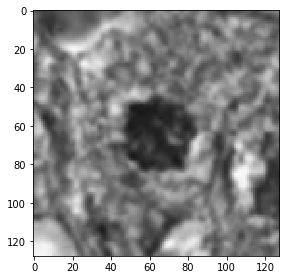

In [56]:
img = io.imread(r"/content/MandNM/mitosis/A00_01_01_CZ8UV4CK9-1a2574be1ed31c6659b0878de25f8c97.png", as_gray=True)

resized = resize(img, (128, 128))
img3 = img_as_ubyte(resized)

imshow(img3)

detector = CENSURE()
detector.detect(resized)
a=detector.keypoints

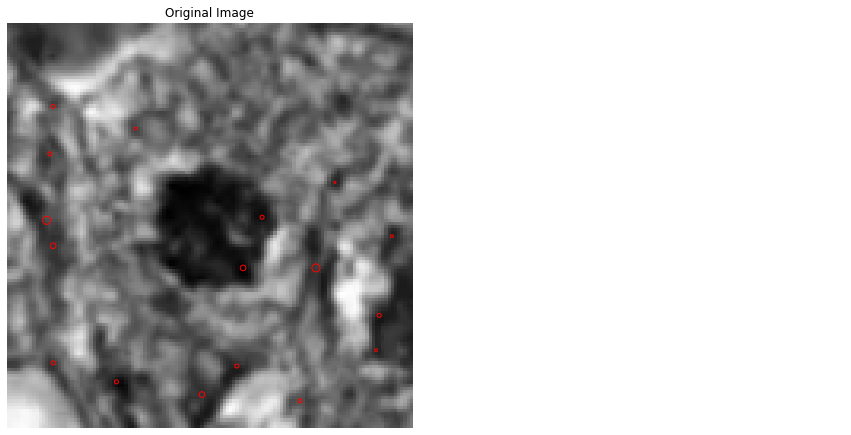

In [57]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

ax[0].imshow(img3, cmap=plt.cm.gray)
ax[0].scatter(detector.keypoints[:, 1], detector.keypoints[:, 0],
              2 ** detector.scales, facecolors='none', edgecolors='r')
ax[0].set_title("Original Image")


for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()

In [58]:
category_censure = []
Array_censure = []
for folder in os.listdir("/content/MandNM/"):

    if(folder == ".DS_Store"):
        continue

    # Loop through each category
    for filename in os.listdir(path.join("/content/MandNM", folder)):

        # Select images which are png and jpg only
        if (filename[-3:] == "png" or filename[-3:] == "jpg"):

            # Get full image by joining
            # all the path to the image
            image = path.join("MandNM", folder, filename)

            # Use open cv to read the image
            img = io.imread(image, as_gray=True)
            resized = resize(img, (128, 128))
            img3 = img_as_ubyte(resized)
            detector = CENSURE()
            detector.detect(img3)
            x_image_features = np.vstack(np.array(detector.keypoints))
            scaler = MinMaxScaler(feature_range=(0,1))
            x_image_scaled = scaler.fit_transform(x_image_features)
            # temp=detector.keypoints.flatten()
            
            category_censure.append(folder)
            Array_censure.append(x_image_scaled.flatten())



# convert the extracted features
# from array to vector
censureArray_np = np.array(Array_censure)


# print("Total feature extracted from the each image",len(censureArray_np[0]))



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [59]:
temp=ptoa(Array_censure)
cen_features=pca_reduction(temp,100)

In [60]:
csvData = []
for id, line in enumerate(cen_features):
  if(id==0):
    temp=[]
    for i in range(0,len(line)):
      temp.append("value"+str(i))
    temp.insert(len(temp),"label")
    csvData.append(temp)

  newImg = line

    # Prepend the category of each image to
    # the begining of the features
  newImg.insert(len(newImg), category[id])
  csvData.append(newImg)


# Save the csv file
with open('result_cen_data.csv', 'w') as csvFile:
    writer = csv.writer(csvFile)
    writer.writerows(csvData)

csvFile.close()

print("Done Extracting Features")

Done Extracting Features


In [61]:
import pandas as pd

feature_cen=pd.read_csv("result_cen_data.csv")
feature_cen['label'] = feature_cen['label'].map({'nonmitosis': 1, 'mitosis': 0})
feature_cen

,value0,value1,value2,value3,value4,value5,value6,value7,value8,value9,value10,value11,value12,value13,value14,value15,value16,value17,value18,value19,value20,value21,value22,value23,value24,value25,value26,value27,value28,value29,value30,value31,value32,value33,value34,value35,value36,value37,value38,value39,...,value61,value62,value63,value64,value65,value66,value67,value68,value69,value70,value71,value72,value73,value74,value75,value76,value77,value78,value79,value80,value81,value82,value83,value84,value85,value86,value87,value88,value89,value90,value91,value92,value93,value94,value95,value96,value97,value98,value99,label
0,2.296623,-0.051966,-0.220455,-1.128011,-0.344703,-0.362474,-0.073460,-0.874536,0.044962,0.378482,0.462561,0.299132,0.718431,-0.144016,0.365616,0.083381,0.170444,-0.298321,0.603586,-0.111797,0.008464,-0.307625,0.482278,-0.282588,0.030891,1.239565,0.404559,-0.147911,-0.215527,0.011392,0.226648,0.321085,0.181398,0.110984,0.351593,-0.190220,0.146611,-0.206870,-0.160419,-0.132960,...,-0.232582,0.190856,-0.110182,0.016562,0.101294,-0.013289,-0.022379,0.142617,-0.060485,-0.030579,0.153639,-0.003250,-0.003374,0.061007,0.055671,0.000514,0.004431,-0.007239,0.038436,0.018814,-0.036160,-0.027531,-0.161275,-0.054689,0.105031,0.106561,0.228769,0.071899,0.002654,-0.008076,-0.006369,0.068168,-0.060377,-0.037021,0.062563,0.002749,-0.024121,0.001668,0.001019,0
1,-1.817147,1.024351,-0.710380,0.088487,0.286964,-0.548556,-0.192767,-0.012468,0.177348,-0.057889,0.037872,0.783494,0.053288,0.096998,0.406639,0.067641,-0.125564,-0.281201,-0.336288,0.348859,-0.132147,0.077854,-0.027494,0.062738,0.155796,0.041639,0.037516,0.101231,0.025744,-0.135326,-0.075567,-0.124572,0.028005,-0.241470,0.081478,-0.008048,0.095513,-0.111458,-0.034547,0.315005,...,-0.020777,0.003598,0.132197,-0.056984,0.009844,-0.013428,-0.000128,0.000216,-0.045647,-0.070398,0.028277,-0.013966,-0.020766,0.028098,0.016949,-0.015143,0.010724,0.053591,0.062739,0.037010,0.027097,-0.005505,-0.015534,-0.007756,0.005762,0.013974,0.001830,0.005803,-0.003302,0.003716,0.004994,-0.005899,0.001880,0.008173,0.013616,0.003599,0.002509,-0.003429,-0.005207,0
2,2.295825,0.147401,-0.318502,-1.033899,-0.279419,-0.416921,-0.170634,-0.446110,-0.081390,0.325180,-0.051147,-0.635301,-0.070335,-0.670366,0.436561,0.423874,-0.307844,-0.591389,0.183570,0.053900,0.149831,-0.009917,0.418710,0.404032,-0.046629,-0.010175,0.523540,0.050690,0.470368,0.034440,0.266567,-0.215215,-0.099330,-0.182664,-0.507657,0.612682,0.141083,-0.104296,0.358425,-0.047790,...,0.358768,-0.226121,0.007238,-0.035963,-0.033542,-0.036713,0.049439,-0.022170,0.014650,0.001304,0.004727,0.075010,0.102991,-0.034318,0.023817,-0.029452,-0.009671,-0.017402,-0.003002,0.049828,0.025331,-0.012696,-0.046013,0.019044,-0.066061,-0.031115,-0.019205,-0.026450,-0.019531,-0.025212,-0.047549,-0.021696,0.005782,-0.009898,0.067717,0.021159,-0.006289,0.040924,-0.009897,0
3,2.126340,1.990145,1.229864,1.117120,0.822273,0.537219,-0.112123,-0.213706,-0.277388,-0.840932,-0.304491,0.325483,-0.030121,-0.172573,-0.221573,-0.690902,0.175513,0.036181,0.197814,0.179991,0.238199,0.266266,-0.321044,0.370971,0.103515,0.128698,0.507753,-0.273179,-0.004808,-0.221655,-0.096042,0.349823,-0.265723,-0.114253,0.309513,0.221624,-0.371700,0.146600,-0.457167,-0.283556,...,0.063063,-0.136368,0.233936,0.106968,-0.225026,-0.090619,-0.077382,-0.007191,0.170346,0.078464,-0.131867,0.165697,0.223521,-0.110526,-0.059140,0.216335,0.031700,-0.062899,0.106548,0.024206,0.057747,-0.096971,0.155277,0.160870,0.155731,0.325385,-0.211103,-0.044601,-0.103035,0.105154,0.140604,0.043617,0.040320,0.020164,0.014588,-0.130987,-0.142469,0.043154,0.009514,0
4,-1.634278,0.476925,0.236491,-0.516965,0.357450,0.030425,0.391533,0.037611,-0.896315,-0.344963,0.202699,-0.194389,0.269745,-0.487703,0.231700,-0.191389,-0.122780,0.075684,-0.382142,-0.013626,0.000833,0.026899,0.002652,0.401946,-0.058468,0.016853,-0.107572,-0.483359,-0.267312,-0.188650,0.250685,-0.396688,0.177142,-0.015242,-0.094048,-0.1687

In [62]:
# feature_cen=normalize(feature_cen)

### classification based on cen features

In [63]:
print("results for gridsearch:")
grid_search(feature_cen.iloc[:,:-1],feature_cen.iloc[:,-1])

results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'gini', 'max_depth': 15, 'max_features': 'log2', 'n_estimators': 500}
The KNN Model is trained well with the given images {'n_neighbors': 15}
The svm Model is trained well with the given images {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}


['Random forest:58.620689655172406',
 'KNN:0.6434782608695652',
 'svm:60.91954022988506']

In [64]:
print("results for random search")
random_search(feature_cen.iloc[:,:-1],feature_cen.iloc[:,-1])

results for random search
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'entropy', 'max_depth': 9, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 77}
The KNN Model is trained well with the given images {'n_neighbors': 16}
The svm Model is trained well with the given images {'C': 1.7321848924362282, 'kernel': 'poly'}


['Random forest:0.5942028985507246',
 'KNN:0.6463768115942029',
 'svm:0.6289855072463769']

In [65]:
# print("results for hyperband")
# hyperband_opt(feature_cen.iloc[:,:-1],feature_cen.iloc[:,-1])

In [66]:
print("results for Bayesian Optimization with Gaussian Process (BO-GP)")
bogp(feature_cen.iloc[:,:-1],feature_cen.iloc[:,-1])

results for Bayesian Optimization with Gaussian Process (BO-GP)
Splitted Successfully
The rf Model is trained well with the given images OrderedDict([('criterion', 'gini'), ('max_depth', 8), ('max_features', 64), ('min_samples_leaf', 11), ('min_samples_split', 2), ('n_estimators', 16)])
The KNN Model is trained well with the given images OrderedDict([('n_neighbors', 11)])


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 0.1), ('kernel', 'sigmoid')])


['Random forest:0.6086956521739131',
 'KNN:0.6376811594202898',
 'svm:0.6550724637681159']

In [67]:
print("results for skopt")
skopt_gp(feature_cen.iloc[:,:-1],feature_cen.iloc[:,-1])

results for skopt
Splitted Successfully


['Random forest:0.6173913043478262',
 'KNN:0.6405797101449275',
 'svm:0.6028985507246377']

In [68]:
print("result for bo_tpe")
bo_tpe(feature_cen.iloc[:,:-1],feature_cen.iloc[:,-1])

result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:01<00:00, 12.52it/s, best loss: -0.6434782608695652]


["Random forest:{'criterion': 1, 'max_depth': 20.0, 'max_features': 29.0, 'min_samples_leaf': 8.0, 'min_samples_split': 7.0, 'n_estimators': 94.0}",
 "KNN:{'n_neighbors': 18.0}",
 "svm:{'C': 1.9452707327178957, 'kernel': 3}"]

In [69]:
print("result for genetic")
genetic(feature_cen.iloc[:,:-1],feature_cen.iloc[:,-1])

result for genetic
Splitted Successfully
Types [1, 1, 1, 1, 1, 1] and maxint [89, 62, 44, 8, 9, 1] detected
--- Evolve in 45927000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.572174	0.544928	0.594203	0.0151281
1  	3     	0.578551	0.533333	0.597101	0.0192792
2  	4     	0.585217	0.568116	0.597101	0.0105668
3  	7     	0.595362	0.594203	0.597101	0.00141999
4  	5     	0.592174	0.565217	0.597101	0.00907853
5  	8     	0.594493	0.57971 	0.597101	0.00509519
Best individual is: {'n_estimators': 78, 'max_features': 2, 'max_depth': 18, 'min_samples_split': 9, 'min_samples_leaf': 6, 'criterion': 'gini'}
with fitness: 0.5971014492753624
The rf Model is trained well with the given images {'n_estimators': 78, 'max_features': 2, 'max_depth': 18, 'min_samples_split': 9, 'min_samples_leaf': 6, 'criterion': 'gini'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.578261	0.498551	0.628986	0.0487138
1  	8     	0.616812	0.582609	0.628986	0.0176693
2  	4     	0.628696	0.626087	0.628986	0.000869565
3  	4     	0.628986	0.628986	0.628986	0          
4  	7     	0.628986	0.628986	0.628986	0          
5  	6     	0.628986	0.628986	0.628986	0          
Best individual is: {'n_neighbors': 12}
with fitness: 0.6289855072463768
The knn Model is trained well with the given images {'n_neighbors': 12}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std     
0  	10    	0.554203	0.507246	0.605797	0.025395
1  	6     	0.570435	0.562319	0.605797	0.0122153
2  	10    	0.570435	0.562319	0.605797	0.0126212
3  	7     	0.576232	0.565217	0.605797	0.0158124
4  	6     	0.587536	0.565217	0.605797	0.0186973
5  	1     	0.605797	0.605797	0.605797	0        
Best individual is: {'C': 3.059980415946156, 'kernel': 'rbf'}
with fitness: 0.6057971014492753
The rf Model is trained well with the given images {'C': 3.059980415946156, 'kernel': 'rbf'}


['Random forest:0.5971014492753624',
 'KNN:0.6289855072463768',
 'svm:0.6057971014492753']

In [70]:
print("result for tpot")
tpot(feature_cen.iloc[:,:-1],feature_cen.iloc[:,-1])

result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.591304347826087	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=77, RandomForestClassifier__max_features=10, RandomForestClassifier__min_samples_leaf=4, RandomForestClassifier__min_samples_split=5, RandomForestClassifier__n_estimators=172)

Generation 2 - Current Pareto front scores:

-1	0.5942028985507246	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=28, RandomForestClassifier__max_features=42, RandomForestClassifier__min_samples_leaf=5, RandomForestClassifier__min_samples_split=10, RandomForestClassifier__n_estimators=194)

Generation 3 - Current Pareto front scores:

-1	0.5942028985507246	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=28, RandomForestClassifier__max_features=42, RandomForestClassifier__min_samples_leaf=5, RandomForestClassif

Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6434782608695652	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=18)

Generation 2 - Current Pareto front scores:

-1	0.6434782608695652	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=18)
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 3 - Current Pareto front scores:

-1	0.6434782608695652	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=18)
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.5681159420289855	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=4.2374075471666774, SVC__kernel=sigmoid)

Generation 2 - Current Pareto front scores:

-1	0.5681159420289855	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=4.2374075471666774, SVC__kernel=sigmoid)

Generation 3 - Current Pareto front scores:

-1	0.5681159420289855	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=4.2374075471666774, SVC__kernel=sigmoid)

-2	0.5971014492753622	SVC(CombineDFs(input_matrix, SVC(input_matrix, SVC__C=3.292797221617877, SVC__kernel=poly)), SVC__C=42.27841608829962, SVC__kernel=sigmoid)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


['Random forest:58.620689655172406',
 'knn:55.172413793103445',
 'svm:49.42528735632184']

### combining hog and orb and cen

In [71]:
orbhogcen_temp=[orb_hog.iloc[:,:-1],feature_cen.iloc[:,:-1],feature_cen.iloc[:,-1]]
orb_hog_cen=pd.concat(orbhogcen_temp, axis=1)
orb_hog_cen

,value0,value1,value2,value3,value4,value5,value6,value7,value8,value9,value10,value11,value12,value13,value14,value15,value16,value17,value18,value19,value20,value21,value22,value23,value24,value25,value26,value27,value28,value29,value30,value31,value32,value33,value34,value35,value36,value37,value38,value39,...,value61,value62,value63,value64,value65,value66,value67,value68,value69,value70,value71,value72,value73,value74,value75,value76,value77,value78,value79,value80,value81,value82,value83,value84,value85,value86,value87,value88,value89,value90,value91,value92,value93,value94,value95,value96,value97,value98,value99,label
0,-1.350751,0.744063,2.828002,1.488705,0.604587,0.198014,-0.088769,-0.586226,-0.196583,-0.338038,0.970625,0.524208,0.312863,-0.274286,-0.399208,0.339142,0.356670,-0.434151,0.363181,-0.653040,-0.532412,-0.297976,0.393039,-0.835502,-0.433321,-0.206350,-0.359925,0.296738,-0.591952,0.402581,-0.563544,0.052543,-0.609162,-0.525276,0.293777,-0.064934,-0.366792,-0.393081,-0.163280,-0.289432,...,-0.232582,0.190856,-0.110182,0.016562,0.101294,-0.013289,-0.022379,0.142617,-0.060485,-0.030579,0.153639,-0.003250,-0.003374,0.061007,0.055671,0.000514,0.004431,-0.007239,0.038436,0.018814,-0.036160,-0.027531,-0.161275,-0.054689,0.105031,0.106561,0.228769,0.071899,0.002654,-0.008076,-0.006369,0.068168,-0.060377,-0.037021,0.062563,0.002749,-0.024121,0.001668,0.001019,0
1,-0.145677,-0.766594,0.868124,-1.994485,-0.357343,0.653924,-0.185722,0.559986,-0.697626,0.829572,-0.918668,-0.602372,0.921835,-1.104932,-0.067057,-0.156607,-0.912433,-0.080461,-0.768110,0.145694,0.620949,0.630911,0.080516,-0.129331,1.195345,-0.079360,-0.798757,-0.968560,-0.140586,-0.065083,0.179707,0.848040,-0.136162,-0.424545,-1.058376,-0.716689,0.388147,-1.045487,-0.589609,0.284796,...,-0.020777,0.003598,0.132197,-0.056984,0.009844,-0.013428,-0.000128,0.000216,-0.045647,-0.070398,0.028277,-0.013966,-0.020766,0.028098,0.016949,-0.015143,0.010724,0.053591,0.062739,0.037010,0.027097,-0.005505,-0.015534,-0.007756,0.005762,0.013974,0.001830,0.005803,-0.003302,0.003716,0.004994,-0.005899,0.001880,0.008173,0.013616,0.003599,0.002509,-0.003429,-0.005207,0
2,-1.506520,0.133689,0.615612,-0.034797,1.117373,0.180478,1.477343,-0.143741,0.282394,-0.112341,-0.404270,1.143333,0.124674,0.009698,-0.261090,-0.664126,-0.790516,0.097044,-1.086370,-0.253277,-0.321761,-0.338633,1.144745,1.994019,-0.570015,0.508359,-0.086749,-1.072047,-0.258218,-0.111115,-0.274512,0.658529,1.173801,-0.611660,-0.202915,1.098538,0.289396,-0.402164,0.136126,0.040257,...,0.358768,-0.226121,0.007238,-0.035963,-0.033542,-0.036713,0.049439,-0.022170,0.014650,0.001304,0.004727,0.075010,0.102991,-0.034318,0.023817,-0.029452,-0.009671,-0.017402,-0.003002,0.049828,0.025331,-0.012696,-0.046013,0.019044,-0.066061,-0.031115,-0.019205,-0.026450,-0.019531,-0.025212,-0.047549,-0.021696,0.005782,-0.009898,0.067717,0.021159,-0.006289,0.040924,-0.009897,0
3,-0.199565,0.465821,-0.423813,-0.461612,-0.213157,0.967217,-0.761422,0.813642,-1.333668,0.504284,0.772371,-0.917347,-0.472559,-0.293107,0.305704,0.269421,-0.452343,0.415729,-0.029141,-0.360837,0.610903,-0.138663,0.124914,0.005689,-0.152032,-0.305016,-0.683944,0.332609,-0.901827,0.042654,0.026320,1.192160,0.225958,-0.302983,-0.005127,-0.064549,-0.064427,-0.048352,0.215616,-0.215420,...,0.063063,-0.136368,0.233936,0.106968,-0.225026,-0.090619,-0.077382,-0.007191,0.170346,0.078464,-0.131867,0.165697,0.223521,-0.110526,-0.059140,0.216335,0.031700,-0.062899,0.106548,0.024206,0.057747,-0.096971,0.155277,0.160870,0.155731,0.325385,-0.211103,-0.044601,-0.103035,0.105154,0.140604,0.043617,0.040320,0.020164,0.014588,-0.130987,-0.142469,0.043154,0.009514,0
4,0.558966,-0.156577,0.162601,-0.740416,-0.197055,-0.523983,-0.546396,-1.123024,-0.565070,-0.247203,-0.054153,0.049199,0.658564,0.728309,-0.534389,0.852255,-1.075244,-0.803030,0.502114,-0.256546,0.377753,0.534239,-0.371512,-0.122626,0.010771,0.764454,-0.154147,-0.639467,0.580875,0.634243,-0.523267,-0.153350,-0.775879,-0.133

### classification based on orb,cen,hog features

In [72]:
print("results for gridsearch:")
grid_search(orb_hog_cen.iloc[:,:-1],orb_hog_cen.iloc[:,-1])

results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'gini', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 500}
The KNN Model is trained well with the given images {'n_neighbors': 10}
The svm Model is trained well with the given images {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}


['Random forest:70.11494252873564',
 'KNN:0.6956521739130435',
 'svm:74.71264367816092']

In [73]:
print("results for random search")
random_search(orb_hog_cen.iloc[:,:-1],orb_hog_cen.iloc[:,-1])

results for random search
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'entropy', 'max_depth': 48, 'max_features': 55, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 24}
The KNN Model is trained well with the given images {'n_neighbors': 7}
The svm Model is trained well with the given images {'C': 1.0491868241419622, 'kernel': 'linear'}


['Random forest:0.744927536231884',
 'KNN:0.6956521739130435',
 'svm:0.7710144927536232']

In [74]:
# print("results for hyperband")
# hyperband_opt(orb_hog_cen.iloc[:,:-1],orb_hog_cen.iloc[:,-1])

In [75]:
print("results for Bayesian Optimization with Gaussian Process (BO-GP)")
bogp(orb_hog_cen.iloc[:,:-1],orb_hog_cen.iloc[:,-1])

results for Bayesian Optimization with Gaussian Process (BO-GP)
Splitted Successfully
The rf Model is trained well with the given images OrderedDict([('criterion', 'entropy'), ('max_depth', 21), ('max_features', 55), ('min_samples_leaf', 7), ('min_samples_split', 9), ('n_estimators', 79)])
The KNN Model is trained well with the given images OrderedDict([('n_neighbors', 10)])


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 10.0), ('kernel', 'sigmoid')])


['Random forest:0.7594202898550725',
 'KNN:0.6956521739130435',
 'svm:0.7710144927536232']

In [76]:
print("results for skopt")
skopt_gp(orb_hog_cen.iloc[:,:-1],orb_hog_cen.iloc[:,-1])

results for skopt
Splitted Successfully


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


['Random forest:0.7478260869565219',
 'KNN:0.7072463768115943',
 'svm:0.7710144927536232']

In [77]:
print("result for bo_tpe")
bo_tpe(orb_hog_cen.iloc[:,:-1],orb_hog_cen.iloc[:,-1])

result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:03<00:00,  6.27it/s, best loss: -0.7710144927536232]


["Random forest:{'criterion': 1, 'max_depth': 31.0, 'max_features': 48.0, 'min_samples_leaf': 10.0, 'min_samples_split': 2.0, 'n_estimators': 98.0}",
 "KNN:{'n_neighbors': 11.0}",
 "svm:{'C': 41.542170831671434, 'kernel': 0}"]

In [78]:
print("result for genetic")
genetic(orb_hog_cen.iloc[:,:-1],orb_hog_cen.iloc[:,-1])

result for genetic
Splitted Successfully
Types [1, 1, 1, 1, 1, 1] and maxint [89, 62, 44, 8, 9, 1] detected
--- Evolve in 45927000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg 	min     	max     	std      
0  	10    	0.68	0.634783	0.733333	0.0251757
1  	6     	0.684058	0.626087	0.718841	0.0220747
2  	8     	0.69942 	0.681159	0.718841	0.0134119
3  	6     	0.714783	0.681159	0.75942 	0.022234 
4  	6     	0.728696	0.684058	0.75942 	0.0235907
5  	7     	0.748406	0.718841	0.75942 	0.0128193
Best individual is: {'n_estimators': 77, 'max_features': 53, 'max_depth': 29, 'min_samples_split': 6, 'min_samples_leaf': 5, 'criterion': 'entropy'}
with fitness: 0.7594202898550725
The rf Model is trained well with the given images {'n_estimators': 77, 'max_features': 53, 'max_depth': 29, 'min_samples_split': 6, 'min_samples_leaf': 5, 'criterion': 'entropy'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.684348	0.649275	0.695652	0.0127305
1  	6     	0.692174	0.684058	0.695652	0.00338026
2  	7     	0.692174	0.681159	0.695652	0.00405797
3  	4     	0.694493	0.692754	0.695652	0.00141999
4  	6     	0.695652	0.695652	0.695652	1.11022e-16
5  	7     	0.695652	0.695652	0.695652	1.11022e-16
Best individual is: {'n_neighbors': 10}
with fitness: 0.6956521739130435
The knn Model is trained well with the given images {'n_neighbors': 10}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.738841	0.686957	0.776812	0.0257449
1  	4     	0.750725	0.730435	0.771014	0.0202899
2  	8     	0.762899	0.730435	0.771014	0.0162319
3  	7     	0.771014	0.771014	0.771014	1.11022e-16
4  	7     	0.771014	0.771014	0.771014	1.11022e-16
5  	5     	0.771014	0.771014	0.771014	1.11022e-16
Best individual is: {'C': 3.649855114016709, 'kernel': 'sigmoid'}
with fitness: 0.7768115942028986
The rf Model is trained well with the given images {'C': 3.649855114016709, 'kernel': 'sigmoid'}


['Random forest:0.7594202898550725',
 'KNN:0.6956521739130435',
 'svm:0.7768115942028986']

In [79]:
print("result for tpot")
tpot(orb_hog_cen.iloc[:,:-1],orb_hog_cen.iloc[:,-1])

result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.736231884057971	RandomForestClassifier(CombineDFs(input_matrix, input_matrix), RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=41, RandomForestClassifier__max_features=50, RandomForestClassifier__min_samples_leaf=9, RandomForestClassifier__min_samples_split=10, RandomForestClassifier__n_estimators=138)

Generation 2 - Current Pareto front scores:

-1	0.736231884057971	RandomForestClassifier(CombineDFs(input_matrix, input_matrix), RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=41, RandomForestClassifier__max_features=50, RandomForestClassifier__min_samples_leaf=9, RandomForestClassifier__min_samples_split=10, RandomForestClassifier__n_estimators=138)

Generation 3 - Current Pareto front scores:

-1	0.736231884057971	RandomForestClassifier(CombineDFs(input_matrix, input_matrix), RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=41, RandomForestClassifier__max_fe

Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7246376811594203	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=11)
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 2 - Current Pareto front scores:

-1	0.7246376811594203	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=11)
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 3 - Current Pareto front scores:

-1	0.7246376811594203	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=11)
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7710144927536232	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=10.184368973849173, SVC__kernel=linear)

Generation 2 - Current Pareto front scores:

-1	0.7710144927536232	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=10.184368973849173, SVC__kernel=linear)
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 3 - Current Pareto front scores:

-1	0.7710144927536232	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=10.184368973849173, SVC__kernel=linear)


['Random forest:67.81609195402298',
 'knn:67.81609195402298',
 'svm:72.41379310344827']

### corner peaks 

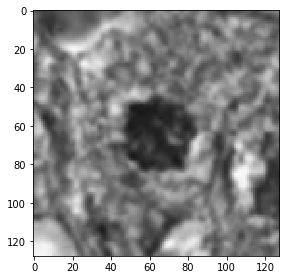

In [80]:
img = io.imread(r"/content/MandNM/mitosis/A00_01_01_CZ8UV4CK9-1a2574be1ed31c6659b0878de25f8c97.png", as_gray=True)

resized = resize(img, (128, 128))
img3 = img_as_ubyte(resized)

imshow(img3)
corners =  corner_peaks(corner_harris(img3),min_distance=1)

In [81]:
corners.flatten()

array([126,   1,   1, ...,  55,  73,   9])

In [82]:
category_corner = []
Array_corner = []
for folder in os.listdir("/content/MandNM/"):

    if(folder == ".DS_Store"):
        continue

    # Loop through each category
    for filename in os.listdir(path.join("/content/MandNM", folder)):

        # Select images which are png and jpg only
        if (filename[-3:] == "png" or filename[-3:] == "jpg"):

            # Get full image by joining
            # all the path to the image
            image = path.join("MandNM", folder, filename)

            # Use open cv to read the image
            img = io.imread(image, as_gray=True)
            resized = resize(img, (128, 128))
            img3 = img_as_ubyte(resized)
            corners =  corner_peaks(corner_harris(img3),min_distance=1)
            x_image_features = np.vstack(np.array(corners))
            scaler = MinMaxScaler(feature_range=(0,1))
            x_image_scaled = scaler.fit_transform(x_image_features)
            
            category_corner.append(folder)
            Array_corner.append(x_image_scaled.flatten())



# convert the extracted features
# from array to vector
cornerArray_np = np.array(Array_corner)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [83]:
temp_corner=ptoa(Array_corner)
corner_features=pca_reduction(temp_corner,400)

In [84]:
csvData = []
for id, line in enumerate(corner_features):
  if(id==0):
    temp=[]
    for i in range(0,len(line)):
      temp.append("value"+str(i))
    temp.insert(len(temp),"label")
    csvData.append(temp)

  newImg = line

    # Prepend the category of each image to
    # the begining of the features
  newImg.insert(len(newImg), category[id])
  csvData.append(newImg)


# Save the csv file
with open('result_cor_data.csv', 'w') as csvFile:
    writer = csv.writer(csvFile)
    writer.writerows(csvData)

csvFile.close()

print("Done Extracting Features")

Done Extracting Features


In [85]:
import pandas as pd

feature_cor=pd.read_csv("result_cor_data.csv")
feature_cor['label'] = feature_cor['label'].map({'nonmitosis': 1, 'mitosis': 0})
feature_cor

,value0,value1,value2,value3,value4,value5,value6,value7,value8,value9,value10,value11,value12,value13,value14,value15,value16,value17,value18,value19,value20,value21,value22,value23,value24,value25,value26,value27,value28,value29,value30,value31,value32,value33,value34,value35,value36,value37,value38,value39,...,value361,value362,value363,value364,value365,value366,value367,value368,value369,value370,value371,value372,value373,value374,value375,value376,value377,value378,value379,value380,value381,value382,value383,value384,value385,value386,value387,value388,value389,value390,value391,value392,value393,value394,value395,value396,value397,value398,value399,label
0,0.504686,-0.902773,-0.688003,-0.323854,-1.858875,0.132872,-0.984312,0.400115,-0.229643,-1.383432,-1.253544,-0.375666,-0.560925,0.561171,-0.664528,-0.393713,1.200924,-0.947478,0.145396,-0.838305,0.139442,0.624318,1.088216,0.033994,1.330336,0.295083,-0.505817,-0.381924,0.297311,-0.204047,0.278019,0.878941,0.674300,-0.723969,0.082290,0.021227,0.579147,1.528054,-0.414907,-0.132464,...,-0.027755,0.504279,0.124814,0.251728,0.249497,0.150109,-0.210888,0.127902,0.153997,-0.198247,0.147568,-0.112144,-0.062285,-0.202060,-0.085241,-0.119375,-0.181122,-0.046240,0.131469,0.037125,-0.241435,-0.163049,0.137746,0.003627,0.197022,-0.116619,0.220956,0.301044,0.051156,0.016899,-0.220437,0.031573,0.071638,0.121501,-0.150489,-0.171149,0.307986,0.111925,0.188826,0
1,2.320933,0.405358,-1.201407,-0.003111,-1.258640,-0.113876,0.403227,0.176919,0.305014,-0.082035,-0.791509,0.560342,-1.380509,-0.663489,0.288320,0.125331,-1.024032,-0.734423,-0.926532,-0.230174,0.156667,0.354302,-0.240444,0.606902,-0.380179,-0.744994,-0.036438,0.266412,-0.417959,-0.362359,1.025248,0.621393,-0.604237,0.709446,0.629821,-0.678898,-0.062460,-0.070222,-0.926169,-1.138417,...,0.477702,-0.247939,-0.067478,0.327250,-0.058255,-0.043644,0.027451,-0.098741,-0.475255,0.396154,0.206967,-0.148086,-0.280950,-0.078351,-0.162687,0.467567,0.166092,-0.217247,0.157618,0.179666,0.505199,0.438630,0.228101,-0.146159,-0.055807,0.061481,-0.473629,0.097104,-0.000957,-0.113119,-0.139557,0.298198,0.365978,0.401500,-0.096565,0.017280,0.095394,0.033915,0.149791,0
2,0.599437,-1.766653,0.388037,0.059415,-0.369028,0.433622,-0.526943,0.692296,-0.837908,0.586857,-0.637306,1.479108,0.783653,0.020198,-1.314158,-0.160362,-0.457582,0.043777,-0.270869,0.027406,-0.221611,-0.662475,-1.006442,0.242833,-0.672812,0.120522,-0.469888,-1.051733,-1.036781,-0.152051,0.097350,0.635201,-0.287219,0.370246,-0.439938,0.008639,0.084412,0.549568,0.838203,-0.141281,...,-0.197289,-0.071509,0.352817,0.295024,0.331617,0.078858,-0.097205,-0.099560,-0.307312,-0.032551,0.191297,0.355909,0.278703,0.061266,0.270352,-0.009030,0.027841,0.161000,0.383044,-0.030168,0.216457,0.205701,0.241366,-0.032605,-0.084264,-0.151107,0.137457,0.421274,0.067831,-0.217268,-0.035157,-0.087302,0.105292,-0.446539,0.326995,-0.168588,0.123039,-0.260406,-0.138021,0
3,-2.667809,-0.464061,-0.107105,0.158820,0.420643,-0.692732,-1.157914,0.869486,-0.067229,-0.388692,-0.056354,-0.510790,0.550463,0.103491,-0.025215,-0.896106,-0.359237,0.742586,0.041815,1.979376,-0.605465,0.008021,-1.220793,-0.300864,-0.533981,0.275256,-0.545627,-0.881723,-0.406609,-0.541201,0.745498,0.120955,1.296182,-0.135070,-0.182299,0.072224,0.260040,0.260803,0.587153,-0.072568,...,0.103586,0.027701,-0.063369,-0.455492,0.024305,-0.156917,-0.032145,-0.182707,0.048387,-0.062903,-0.017938,-0.130463,0.066188,-0.109971,-0.107182,0.535664,-0.034885,-0.154339,0.127239,0.327985,0.177554,-0.193381,-0.056707,-0.295919,0.266537,0.016078,0.505739,0.113462,-0.102473,0.048210,0.220366,-0.286595,0.200061,-0.043037,-0.200609,0.243163,-0.449981,-0.180798,-0.142604,0
4,-1.163599,0.222124,0.366801,-1.828606,1.711191,0.071710,-0.499346,0.562599,1.015144,1.224204,-0.639294,0.477608,-0.330429,0.848065,-0.315638,0.644992,-0.790569,0.515902,-1.259212,0.130271,-0.048727,-1.005871,-0.622410,0.231176,-0.887086,0.577891,-0.021544,-1.342743,-1.160242,-0.271826,0.1

In [86]:
# feature_cor=normalize(feature_cor)

In [87]:
feature_cor

,value0,value1,value2,value3,value4,value5,value6,value7,value8,value9,value10,value11,value12,value13,value14,value15,value16,value17,value18,value19,value20,value21,value22,value23,value24,value25,value26,value27,value28,value29,value30,value31,value32,value33,value34,value35,value36,value37,value38,value39,...,value361,value362,value363,value364,value365,value366,value367,value368,value369,value370,value371,value372,value373,value374,value375,value376,value377,value378,value379,value380,value381,value382,value383,value384,value385,value386,value387,value388,value389,value390,value391,value392,value393,value394,value395,value396,value397,value398,value399,label
0,0.504686,-0.902773,-0.688003,-0.323854,-1.858875,0.132872,-0.984312,0.400115,-0.229643,-1.383432,-1.253544,-0.375666,-0.560925,0.561171,-0.664528,-0.393713,1.200924,-0.947478,0.145396,-0.838305,0.139442,0.624318,1.088216,0.033994,1.330336,0.295083,-0.505817,-0.381924,0.297311,-0.204047,0.278019,0.878941,0.674300,-0.723969,0.082290,0.021227,0.579147,1.528054,-0.414907,-0.132464,...,-0.027755,0.504279,0.124814,0.251728,0.249497,0.150109,-0.210888,0.127902,0.153997,-0.198247,0.147568,-0.112144,-0.062285,-0.202060,-0.085241,-0.119375,-0.181122,-0.046240,0.131469,0.037125,-0.241435,-0.163049,0.137746,0.003627,0.197022,-0.116619,0.220956,0.301044,0.051156,0.016899,-0.220437,0.031573,0.071638,0.121501,-0.150489,-0.171149,0.307986,0.111925,0.188826,0
1,2.320933,0.405358,-1.201407,-0.003111,-1.258640,-0.113876,0.403227,0.176919,0.305014,-0.082035,-0.791509,0.560342,-1.380509,-0.663489,0.288320,0.125331,-1.024032,-0.734423,-0.926532,-0.230174,0.156667,0.354302,-0.240444,0.606902,-0.380179,-0.744994,-0.036438,0.266412,-0.417959,-0.362359,1.025248,0.621393,-0.604237,0.709446,0.629821,-0.678898,-0.062460,-0.070222,-0.926169,-1.138417,...,0.477702,-0.247939,-0.067478,0.327250,-0.058255,-0.043644,0.027451,-0.098741,-0.475255,0.396154,0.206967,-0.148086,-0.280950,-0.078351,-0.162687,0.467567,0.166092,-0.217247,0.157618,0.179666,0.505199,0.438630,0.228101,-0.146159,-0.055807,0.061481,-0.473629,0.097104,-0.000957,-0.113119,-0.139557,0.298198,0.365978,0.401500,-0.096565,0.017280,0.095394,0.033915,0.149791,0
2,0.599437,-1.766653,0.388037,0.059415,-0.369028,0.433622,-0.526943,0.692296,-0.837908,0.586857,-0.637306,1.479108,0.783653,0.020198,-1.314158,-0.160362,-0.457582,0.043777,-0.270869,0.027406,-0.221611,-0.662475,-1.006442,0.242833,-0.672812,0.120522,-0.469888,-1.051733,-1.036781,-0.152051,0.097350,0.635201,-0.287219,0.370246,-0.439938,0.008639,0.084412,0.549568,0.838203,-0.141281,...,-0.197289,-0.071509,0.352817,0.295024,0.331617,0.078858,-0.097205,-0.099560,-0.307312,-0.032551,0.191297,0.355909,0.278703,0.061266,0.270352,-0.009030,0.027841,0.161000,0.383044,-0.030168,0.216457,0.205701,0.241366,-0.032605,-0.084264,-0.151107,0.137457,0.421274,0.067831,-0.217268,-0.035157,-0.087302,0.105292,-0.446539,0.326995,-0.168588,0.123039,-0.260406,-0.138021,0
3,-2.667809,-0.464061,-0.107105,0.158820,0.420643,-0.692732,-1.157914,0.869486,-0.067229,-0.388692,-0.056354,-0.510790,0.550463,0.103491,-0.025215,-0.896106,-0.359237,0.742586,0.041815,1.979376,-0.605465,0.008021,-1.220793,-0.300864,-0.533981,0.275256,-0.545627,-0.881723,-0.406609,-0.541201,0.745498,0.120955,1.296182,-0.135070,-0.182299,0.072224,0.260040,0.260803,0.587153,-0.072568,...,0.103586,0.027701,-0.063369,-0.455492,0.024305,-0.156917,-0.032145,-0.182707,0.048387,-0.062903,-0.017938,-0.130463,0.066188,-0.109971,-0.107182,0.535664,-0.034885,-0.154339,0.127239,0.327985,0.177554,-0.193381,-0.056707,-0.295919,0.266537,0.016078,0.505739,0.113462,-0.102473,0.048210,0.220366,-0.286595,0.200061,-0.043037,-0.200609,0.243163,-0.449981,-0.180798,-0.142604,0
4,-1.163599,0.222124,0.366801,-1.828606,1.711191,0.071710,-0.499346,0.562599,1.015144,1.224204,-0.639294,0.477608,-0.330429,0.848065,-0.315638,0.644992,-0.790569,0.515902,-1.259212,0.130271,-0.048727,-1.005871,-0.622410,0.231176,-0.887086,0.577891,-0.021544,-1.342743,-1.160242,-0.271826,0.1

### classification based on corner features

In [88]:
print("results for gridsearch:")
grid_search(feature_cor.iloc[:,:-1],feature_cor.iloc[:,-1])

results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'gini', 'max_depth': 15, 'max_features': 'log2', 'n_estimators': 500}
The KNN Model is trained well with the given images {'n_neighbors': 10}
The svm Model is trained well with the given images {'C': 10, 'gamma': 0.001, 'kernel': 'sigmoid'}


['Random forest:57.47126436781609',
 'KNN:0.6695652173913044',
 'svm:59.77011494252874']

In [89]:
print("results for random search")
random_search(feature_cor.iloc[:,:-1],feature_cor.iloc[:,-1])

results for random search
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'entropy', 'max_depth': 12, 'max_features': 56, 'min_samples_leaf': 10, 'min_samples_split': 9, 'n_estimators': 78}
The KNN Model is trained well with the given images {'n_neighbors': 16}
The svm Model is trained well with the given images {'C': 36.08163144995076, 'kernel': 'rbf'}


['Random forest:0.5942028985507246',
 'KNN:0.6840579710144928',
 'svm:0.6985507246376811']

In [90]:
# print("results for hyperband")
# hyperband_opt(feature_cen.iloc[:,:-1],feature_cen.iloc[:,-1])

In [91]:
print("results for Bayesian Optimization with Gaussian Process (BO-GP)")
bogp(feature_cor.iloc[:,:-1],feature_cor.iloc[:,-1])

results for Bayesian Optimization with Gaussian Process (BO-GP)
Splitted Successfully
The rf Model is trained well with the given images OrderedDict([('criterion', 'gini'), ('max_depth', 27), ('max_features', 52), ('min_samples_leaf', 3), ('min_samples_split', 6), ('n_estimators', 85)])
The KNN Model is trained well with the given images OrderedDict([('n_neighbors', 16)])


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 10.0), ('kernel', 'rbf')])


['Random forest:0.6028985507246376',
 'KNN:0.6840579710144928',
 'svm:0.6985507246376811']

In [92]:
print("results for skopt")
skopt_gp(feature_cor.iloc[:,:-1],feature_cor.iloc[:,-1])

results for skopt
Splitted Successfully


['Random forest:0.6173913043478262',
 'KNN:0.672463768115942',
 'svm:0.6985507246376811']

In [93]:
print("result for bo_tpe")
bo_tpe(feature_cor.iloc[:,:-1],feature_cor.iloc[:,-1])

result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:01<00:00, 12.01it/s, best loss: -0.6985507246376811]


["Random forest:{'criterion': 0, 'max_depth': 23.0, 'max_features': 43.0, 'min_samples_leaf': 10.0, 'min_samples_split': 10.0, 'n_estimators': 79.0}",
 "KNN:{'n_neighbors': 17.0}",
 "svm:{'C': 1.9397152849656067, 'kernel': 2}"]

In [94]:
print("result for genetic")
genetic(feature_cor.iloc[:,:-1],feature_cor.iloc[:,-1])

result for genetic
Splitted Successfully
Types [1, 1, 1, 1, 1, 1] and maxint [89, 62, 44, 8, 9, 1] detected
--- Evolve in 45927000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.536522	0.498551	0.582609	0.0299674
1  	6     	0.547536	0.515942	0.585507	0.0273587
2  	5     	0.569855	0.530435	0.585507	0.0200063
3  	7     	0.581159	0.576812	0.585507	0.00434783
4  	1     	0.584638	0.576812	0.585507	0.0026087 
5  	5     	0.585797	0.585507	0.588406	0.000869565
Best individual is: {'n_estimators': 75, 'max_features': 54, 'max_depth': 14, 'min_samples_split': 9, 'min_samples_leaf': 1, 'criterion': 'gini'}
with fitness: 0.5884057971014492
The rf Model is trained well with the given images {'n_estimators': 75, 'max_features': 54, 'max_depth': 14, 'min_samples_split': 9, 'min_samples_leaf': 1, 'criterion': 'gini'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.651014	0.626087	0.684058	0.0203807
1  	4     	0.665797	0.634783	0.684058	0.0172968
2  	3     	0.675652	0.657971	0.684058	0.00902283
3  	8     	0.681159	0.669565	0.684058	0.0057971 
4  	4     	0.678261	0.626087	0.684058	0.0173913 
5  	5     	0.682609	0.669565	0.684058	0.00434783
Best individual is: {'n_neighbors': 16}
with fitness: 0.6840579710144927
The knn Model is trained well with the given images {'n_neighbors': 16}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min	max     	std      
0  	10    	0.627826	0.6	0.698551	0.0257041
1  	6     	0.647826	0.623188	0.698551	0.0332324
2  	5     	0.669565	0.626087	0.698551	0.0354999
3  	9     	0.698551	0.698551	0.698551	0        
4  	5     	0.698551	0.698551	0.698551	0        
5  	7     	0.698551	0.698551	0.698551	0        
Best individual is: {'C': 10.110740934849671, 'kernel': 'rbf'}
with fitness: 0.6985507246376812
The rf Model is trained well with the given images {'C': 10.110740934849671, 'kernel': 'rbf'}


['Random forest:0.5884057971014492',
 'KNN:0.6840579710144927',
 'svm:0.6985507246376812']

In [95]:
print("result for tpot")
tpot(feature_cor.iloc[:,:-1],feature_cor.iloc[:,-1])

result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6086956521739131	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=43, RandomForestClassifier__max_features=44, RandomForestClassifier__min_samples_leaf=8, RandomForestClassifier__min_samples_split=9, RandomForestClassifier__n_estimators=75)

Generation 2 - Current Pareto front scores:

-1	0.6086956521739131	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=43, RandomForestClassifier__max_features=44, RandomForestClassifier__min_samples_leaf=8, RandomForestClassifier__min_samples_split=9, RandomForestClassifier__n_estimators=75)

Generation 3 - Current Pareto front scores:

-1	0.6202898550724638	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=40, RandomForestClassifier__max_features=42, RandomForestClassifier__min_samples_leaf=10, RandomForestClassifier_

Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6840579710144928	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=16)

-2	0.6898550724637681	KNeighborsClassifier(KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=10), KNeighborsClassifier__n_neighbors=18)

Generation 2 - Current Pareto front scores:

-1	0.6840579710144928	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=16)

-2	0.6927536231884058	KNeighborsClassifier(KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=18), KNeighborsClassifier__n_neighbors=18)

Generation 3 - Current Pareto front scores:

-1	0.6840579710144928	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=16)

-2	0.6927536231884058	KNeighborsClassifier(KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=18), KNeighborsClassifier__n_neighbors=18)
1 operators have been imported by TPOT.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6985507246376811	SVC(input_matrix, SVC__C=10.125632648458538, SVC__kernel=rbf)

Generation 2 - Current Pareto front scores:

-1	0.6985507246376811	SVC(input_matrix, SVC__C=10.125632648458538, SVC__kernel=rbf)

Generation 3 - Current Pareto front scores:

-1	0.6985507246376811	SVC(input_matrix, SVC__C=10.125632648458538, SVC__kernel=rbf)


['Random forest:66.66666666666666',
 'knn:60.91954022988506',
 'svm:58.620689655172406']

### combining hog and orb and cen

In [96]:
orbhogcencor_temp=[orb_hog_cen.iloc[:,:-1],feature_cor.iloc[:,:-1],feature_cor.iloc[:,-1]]
orb_hog_cen_cor=pd.concat(orbhogcencor_temp, axis=1)
orb_hog_cen_cor

,value0,value1,value2,value3,value4,value5,value6,value7,value8,value9,value10,value11,value12,value13,value14,value15,value16,value17,value18,value19,value20,value21,value22,value23,value24,value25,value26,value27,value28,value29,value30,value31,value32,value33,value34,value35,value36,value37,value38,value39,...,value361,value362,value363,value364,value365,value366,value367,value368,value369,value370,value371,value372,value373,value374,value375,value376,value377,value378,value379,value380,value381,value382,value383,value384,value385,value386,value387,value388,value389,value390,value391,value392,value393,value394,value395,value396,value397,value398,value399,label
0,-1.350751,0.744063,2.828002,1.488705,0.604587,0.198014,-0.088769,-0.586226,-0.196583,-0.338038,0.970625,0.524208,0.312863,-0.274286,-0.399208,0.339142,0.356670,-0.434151,0.363181,-0.653040,-0.532412,-0.297976,0.393039,-0.835502,-0.433321,-0.206350,-0.359925,0.296738,-0.591952,0.402581,-0.563544,0.052543,-0.609162,-0.525276,0.293777,-0.064934,-0.366792,-0.393081,-0.163280,-0.289432,...,-0.027755,0.504279,0.124814,0.251728,0.249497,0.150109,-0.210888,0.127902,0.153997,-0.198247,0.147568,-0.112144,-0.062285,-0.202060,-0.085241,-0.119375,-0.181122,-0.046240,0.131469,0.037125,-0.241435,-0.163049,0.137746,0.003627,0.197022,-0.116619,0.220956,0.301044,0.051156,0.016899,-0.220437,0.031573,0.071638,0.121501,-0.150489,-0.171149,0.307986,0.111925,0.188826,0
1,-0.145677,-0.766594,0.868124,-1.994485,-0.357343,0.653924,-0.185722,0.559986,-0.697626,0.829572,-0.918668,-0.602372,0.921835,-1.104932,-0.067057,-0.156607,-0.912433,-0.080461,-0.768110,0.145694,0.620949,0.630911,0.080516,-0.129331,1.195345,-0.079360,-0.798757,-0.968560,-0.140586,-0.065083,0.179707,0.848040,-0.136162,-0.424545,-1.058376,-0.716689,0.388147,-1.045487,-0.589609,0.284796,...,0.477702,-0.247939,-0.067478,0.327250,-0.058255,-0.043644,0.027451,-0.098741,-0.475255,0.396154,0.206967,-0.148086,-0.280950,-0.078351,-0.162687,0.467567,0.166092,-0.217247,0.157618,0.179666,0.505199,0.438630,0.228101,-0.146159,-0.055807,0.061481,-0.473629,0.097104,-0.000957,-0.113119,-0.139557,0.298198,0.365978,0.401500,-0.096565,0.017280,0.095394,0.033915,0.149791,0
2,-1.506520,0.133689,0.615612,-0.034797,1.117373,0.180478,1.477343,-0.143741,0.282394,-0.112341,-0.404270,1.143333,0.124674,0.009698,-0.261090,-0.664126,-0.790516,0.097044,-1.086370,-0.253277,-0.321761,-0.338633,1.144745,1.994019,-0.570015,0.508359,-0.086749,-1.072047,-0.258218,-0.111115,-0.274512,0.658529,1.173801,-0.611660,-0.202915,1.098538,0.289396,-0.402164,0.136126,0.040257,...,-0.197289,-0.071509,0.352817,0.295024,0.331617,0.078858,-0.097205,-0.099560,-0.307312,-0.032551,0.191297,0.355909,0.278703,0.061266,0.270352,-0.009030,0.027841,0.161000,0.383044,-0.030168,0.216457,0.205701,0.241366,-0.032605,-0.084264,-0.151107,0.137457,0.421274,0.067831,-0.217268,-0.035157,-0.087302,0.105292,-0.446539,0.326995,-0.168588,0.123039,-0.260406,-0.138021,0
3,-0.199565,0.465821,-0.423813,-0.461612,-0.213157,0.967217,-0.761422,0.813642,-1.333668,0.504284,0.772371,-0.917347,-0.472559,-0.293107,0.305704,0.269421,-0.452343,0.415729,-0.029141,-0.360837,0.610903,-0.138663,0.124914,0.005689,-0.152032,-0.305016,-0.683944,0.332609,-0.901827,0.042654,0.026320,1.192160,0.225958,-0.302983,-0.005127,-0.064549,-0.064427,-0.048352,0.215616,-0.215420,...,0.103586,0.027701,-0.063369,-0.455492,0.024305,-0.156917,-0.032145,-0.182707,0.048387,-0.062903,-0.017938,-0.130463,0.066188,-0.109971,-0.107182,0.535664,-0.034885,-0.154339,0.127239,0.327985,0.177554,-0.193381,-0.056707,-0.295919,0.266537,0.016078,0.505739,0.113462,-0.102473,0.048210,0.220366,-0.286595,0.200061,-0.043037,-0.200609,0.243163,-0.449981,-0.180798,-0.142604,0
4,0.558966,-0.156577,0.162601,-0.740416,-0.197055,-0.523983,-0.546396,-1.123024,-0.565070,-0.247203,-0.054153,0.049199,0.658564,0.728309,-0.534389,0.852255,-1.075244,-0.803030,0.502114,-0.256546,0.377753,0.534239,-0.371512,-0.122626,0.010771,0.764454,-0.154147,-0.639467,0.580875,0.63

### classification based on hog,censure,orb corner features

In [97]:
print("results for gridsearch:")
grid_search(orb_hog_cen_cor.iloc[:,:-1],orb_hog_cen_cor.iloc[:,-1])

results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 500}
The KNN Model is trained well with the given images {'n_neighbors': 5}
The svm Model is trained well with the given images {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}


['Random forest:72.41379310344827',
 'KNN:0.7130434782608696',
 'svm:78.16091954022988']

In [98]:
print("results for random search")
random_search(orb_hog_cen_cor.iloc[:,:-1],orb_hog_cen_cor.iloc[:,-1])

results for random search
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'entropy', 'max_depth': 47, 'max_features': 46, 'min_samples_leaf': 10, 'min_samples_split': 6, 'n_estimators': 99}
The KNN Model is trained well with the given images {'n_neighbors': 14}
The svm Model is trained well with the given images {'C': 39.613019191566714, 'kernel': 'sigmoid'}


['Random forest:0.7188405797101449',
 'KNN:0.7072463768115943',
 'svm:0.7971014492753623']

In [99]:
# print("results for hyperband")
# hyperband_opt(feature_cen.iloc[:,:-1],feature_cen.iloc[:,-1])

In [100]:
print("results for Bayesian Optimization with Gaussian Process (BO-GP)")
bogp(orb_hog_cen_cor.iloc[:,:-1],orb_hog_cen_cor.iloc[:,-1])

results for Bayesian Optimization with Gaussian Process (BO-GP)
Splitted Successfully
The rf Model is trained well with the given images OrderedDict([('criterion', 'gini'), ('max_depth', 50), ('max_features', 64), ('min_samples_leaf', 11), ('min_samples_split', 11), ('n_estimators', 100)])
The KNN Model is trained well with the given images OrderedDict([('n_neighbors', 12)])


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 10.0), ('kernel', 'sigmoid')])


['Random forest:0.7246376811594203',
 'KNN:0.7130434782608696',
 'svm:0.7999999999999999']

In [101]:
print("results for skopt")
skopt_gp(orb_hog_cen_cor.iloc[:,:-1],orb_hog_cen_cor.iloc[:,-1])

results for skopt
Splitted Successfully


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


['Random forest:0.736231884057971',
 'KNN:0.7130434782608696',
 'svm:0.7999999999999999']

In [102]:
print("result for bo_tpe")
bo_tpe(orb_hog_cen_cor.iloc[:,:-1],orb_hog_cen_cor.iloc[:,-1])

result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:04<00:00,  4.76it/s, best loss: -0.7971014492753623]


["Random forest:{'criterion': 0, 'max_depth': 30.0, 'max_features': 61.0, 'min_samples_leaf': 7.0, 'min_samples_split': 9.0, 'n_estimators': 70.0}",
 "KNN:{'n_neighbors': 11.0}",
 "svm:{'C': -19.97129827022799, 'kernel': 0}"]

In [103]:
print("result for genetic")
genetic(orb_hog_cen_cor.iloc[:,:-1],orb_hog_cen_cor.iloc[:,-1])

result for genetic
Splitted Successfully
Types [1, 1, 1, 1, 1, 1] and maxint [89, 62, 44, 8, 9, 1] detected
--- Evolve in 45927000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.655942	0.591304	0.721739	0.0397017
1  	5     	0.671884	0.605797	0.721739	0.0391637
2  	7     	0.712464	0.675362	0.721739	0.0185507
3  	1     	0.721739	0.721739	0.721739	0        
4  	7     	0.71971 	0.701449	0.721739	0.00608696
5  	8     	0.721739	0.721739	0.721739	0         
Best individual is: {'n_estimators': 85, 'max_features': 62, 'max_depth': 38, 'min_samples_split': 6, 'min_samples_leaf': 4, 'criterion': 'gini'}
with fitness: 0.7217391304347827
The rf Model is trained well with the given images {'n_estimators': 85, 'max_features': 62, 'max_depth': 38, 'min_samples_split': 6, 'min_samples_leaf': 4, 'criterion': 'gini'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.698841	0.669565	0.713043	0.0119826
1  	5     	0.706667	0.695652	0.713043	0.00463768
2  	5     	0.710725	0.707246	0.713043	0.00283999
3  	10    	0.713043	0.713043	0.713043	1.11022e-16
4  	4     	0.713043	0.713043	0.713043	1.11022e-16
5  	6     	0.713043	0.713043	0.713043	1.11022e-16
Best individual is: {'n_neighbors': 5}
with fitness: 0.7130434782608696
The knn Model is trained well with the given images {'n_neighbors': 5}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.768406	0.684058	0.797101	0.0382444
1  	8     	0.798551	0.797101	0.811594	0.00434783
2  	5     	0.797101	0.797101	0.797101	0         
3  	7     	0.797101	0.797101	0.797101	0         
4  	9     	0.797101	0.797101	0.797101	0         
5  	4     	0.797101	0.797101	0.797101	0         
Best individual is: {'C': 3.2039265361351985, 'kernel': 'sigmoid'}
with fitness: 0.8115942028985508
The rf Model is trained well with the given images {'C': 3.2039265361351985, 'kernel': 'sigmoid'}


['Random forest:0.7217391304347827',
 'KNN:0.7130434782608696',
 'svm:0.8115942028985508']

In [104]:
print("result for tpot")
tpot(orb_hog_cen_cor.iloc[:,:-1],orb_hog_cen_cor.iloc[:,-1])

result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7246376811594203	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=36, RandomForestClassifier__max_features=58, RandomForestClassifier__min_samples_leaf=7, RandomForestClassifier__min_samples_split=8, RandomForestClassifier__n_estimators=132)

Generation 2 - Current Pareto front scores:

-1	0.7304347826086958	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=36, RandomForestClassifier__max_features=58, RandomForestClassifier__min_samples_leaf=6, RandomForestClassifier__min_samples_split=8, RandomForestClassifier__n_estimators=132)

Generation 3 - Current Pareto front scores:

-1	0.7304347826086958	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=36, RandomForestClassifier__max_features=58, RandomForestClassifier__min_samples_leaf=6, RandomForestC

Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6956521739130435	KNeighborsClassifier(CombineDFs(input_matrix, input_matrix), KNeighborsClassifier__n_neighbors=15)

-2	0.7188405797101449	KNeighborsClassifier(KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=8), KNeighborsClassifier__n_neighbors=12)

Generation 2 - Current Pareto front scores:

-1	0.6956521739130435	KNeighborsClassifier(CombineDFs(input_matrix, input_matrix), KNeighborsClassifier__n_neighbors=15)

-2	0.7188405797101449	KNeighborsClassifier(KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=8), KNeighborsClassifier__n_neighbors=12)

Generation 3 - Current Pareto front scores:

-1	0.6956521739130435	KNeighborsClassifier(CombineDFs(input_matrix, input_matrix), KNeighborsClassifier__n_neighbors=15)

-2	0.7188405797101449	KNeighborsClassifier(KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=8), KNeighborsClassifier__n_neighbors=12)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7971014492753623	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=42.04728990939902, SVC__kernel=sigmoid)

Generation 2 - Current Pareto front scores:

-1	0.7971014492753623	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=42.04728990939902, SVC__kernel=sigmoid)

Generation 3 - Current Pareto front scores:

-1	0.7971014492753623	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=42.04728990939902, SVC__kernel=sigmoid)


['Random forest:78.16091954022988',
 'knn:70.11494252873564',
 'svm:75.86206896551724']

### edgeExtract 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  # Remove the CWD from sys.path while we load stuff.


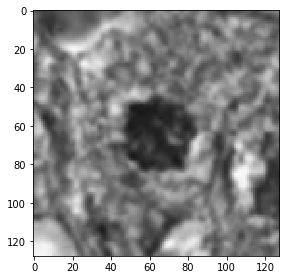

In [105]:
img = io.imread(r"/content/MandNM/mitosis/A00_01_01_CZ8UV4CK9-1a2574be1ed31c6659b0878de25f8c97.png", as_gray=True)

resized = resize(img, (128, 128))
img3 = img_as_ubyte(resized)

imshow(img3)
edge =  edgeExtract(resized, 100)

In [106]:
category_edge = []
Array_edge = []
for folder in os.listdir("/content/MandNM/"):

    if(folder == ".DS_Store"):
        continue

    # Loop through each category
    for filename in os.listdir(path.join("/content/MandNM", folder)):

        # Select images which are png and jpg only
        if (filename[-3:] == "png" or filename[-3:] == "jpg"):

            # Get full image by joining
            # all the path to the image
            image = path.join("MandNM", folder, filename)

            # Use open cv to read the image
            img = io.imread(image, as_gray=True)
            resized = resize(img, (128, 128))
            img3 = img_as_ubyte(resized)
            edge =  edgeExtract(img, 100)
            
            category_edge.append(folder)
            Array_edge.append(edge)



# convert the extracted features
# from array to vector
edgeArray_np = np.array(Array_edge)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  # Remove the CWD from sys.path while we load stuff.


In [107]:
edge_features=pca_reduction(edgeArray_np,n=200)

In [108]:
csvData = []
for id, line in enumerate(edge_features):
  if(id==0):
    temp=[]
    for i in range(0,len(line)):
      temp.append("value"+str(i))
    temp.insert(len(temp),"label")
    csvData.append(temp)

  newImg = line

    # Prepend the category of each image to
    # the begining of the features
  newImg.insert(len(newImg), category[id])
  csvData.append(newImg)


# Save the csv file
with open('result_edge_data.csv', 'w') as csvFile:
    writer = csv.writer(csvFile)
    writer.writerows(csvData)

csvFile.close()

print("Done Extracting Features")

Done Extracting Features


In [109]:
import pandas as pd

feature_edge=pd.read_csv("result_edge_data.csv")
feature_edge['label'] = feature_edge['label'].map({'nonmitosis': 1, 'mitosis': 0})
feature_edge

,value0,value1,value2,value3,value4,value5,value6,value7,value8,value9,value10,value11,value12,value13,value14,value15,value16,value17,value18,value19,value20,value21,value22,value23,value24,value25,value26,value27,value28,value29,value30,value31,value32,value33,value34,value35,value36,value37,value38,value39,...,value161,value162,value163,value164,value165,value166,value167,value168,value169,value170,value171,value172,value173,value174,value175,value176,value177,value178,value179,value180,value181,value182,value183,value184,value185,value186,value187,value188,value189,value190,value191,value192,value193,value194,value195,value196,value197,value198,value199,label
0,-2.514482,2.188668,0.643369,-0.268219,0.143264,-0.275228,0.070690,0.421571,0.214383,0.583270,0.304150,0.386061,-0.028473,0.126296,-0.066119,-0.122023,-0.198384,0.123802,0.034479,-0.033014,-0.058386,0.027626,0.052266,-0.000678,-0.110727,-0.038198,0.040940,0.006962,-0.024911,0.183649,0.056991,0.014265,0.031450,-0.001051,0.106521,-0.033588,-0.070606,-0.096383,0.032255,-0.049246,...,-4.312405e-16,-3.631789e-18,-3.171282e-16,-1.117606e-16,1.405545e-16,-6.115133e-16,7.151372e-17,-1.476451e-16,6.470401e-17,-1.068417e-16,-7.346719e-17,3.572670e-18,2.599009e-17,-1.833035e-16,-1.287863e-16,-1.949767e-16,-5.722046e-16,3.766112e-17,-6.460713e-17,4.423118e-17,1.059437e-16,2.096119e-16,-4.659307e-17,1.583672e-16,-8.315922e-17,-4.356629e-16,1.085813e-16,4.211484e-17,-2.451545e-16,4.330763e-16,-2.040409e-16,-6.570858e-17,-2.816110e-17,-3.896984e-17,-7.328506e-17,1.138648e-16,-7.931110e-17,-2.962945e-16,-4.188854e-17,0
1,5.769432,-3.165627,-0.252778,-0.450419,-0.481630,-0.179294,0.237855,-0.363403,0.472865,0.491145,0.203522,-0.010435,0.360369,-0.233120,0.063308,-0.035534,-0.055027,-0.131215,-0.073760,-0.155638,-0.041598,0.048821,0.010814,0.078890,0.066471,0.008461,-0.002802,0.077884,0.020188,0.044594,-0.006437,-0.067570,0.023229,0.019580,-0.033299,0.002417,0.009991,0.029260,0.012998,-0.018952,...,2.363599e-16,-3.237077e-17,4.750306e-16,-1.029291e-16,-7.518830e-17,1.973913e-16,-5.072722e-17,-4.243178e-16,-1.028405e-16,4.097488e-16,-1.850936e-16,-1.466367e-16,1.933324e-17,5.850142e-16,1.348349e-16,4.318419e-16,3.133373e-16,4.705889e-16,-2.171723e-16,3.267196e-16,-3.625830e-16,4.415567e-17,-1.244542e-16,-2.736414e-17,-1.754899e-16,2.767804e-16,3.092662e-17,-1.117392e-16,-8.051046e-17,5.639065e-17,-3.634995e-17,1.567531e-16,-5.469741e-17,-1.285910e-16,-5.854643e-16,-1.097009e-16,4.539315e-16,-4.348068e-16,5.741094e-17,0
2,-2.048722,-0.515451,0.202461,-0.300849,0.200841,-0.259023,-0.583347,-0.214611,0.112977,-0.592147,0.019486,0.209213,-0.294679,-0.013591,0.423455,0.070706,0.259877,-0.102732,0.093026,0.050874,0.101194,-0.148814,-0.007913,-0.186132,-0.104760,-0.091887,0.089654,0.126276,0.014456,0.102105,-0.014983,-0.063496,-0.054675,0.004410,-0.029130,0.011440,0.034464,0.088235,-0.033863,-0.019458,...,-3.611610e-16,-5.350805e-16,-3.588181e-16,5.209539e-17,-4.553007e-16,-1.986018e-17,-1.229863e-16,2.339023e-16,1.639474e-16,-2.881933e-16,1.352590e-16,-2.813552e-16,2.331833e-16,-4.977362e-16,-5.674930e-17,7.126006e-17,1.211068e-16,-2.798752e-16,-1.273818e-16,-2.119991e-16,4.250799e-16,-3.010261e-16,-7.352926e-16,1.365840e-16,-3.473355e-16,7.602807e-16,-2.109552e-16,4.544041e-16,6.343191e-16,3.061199e-16,7.434227e-17,2.549455e-16,-5.616897e-16,4.137020e-17,-4.903448e-16,-8.834241e-16,-3.525561e-16,-1.318410e-16,-7.328663e-16,0
3,-5.035313,1.789364,-0.291303,0.170918,0.566251,0.039682,-0.321621,0.044445,-0.344086,-0.108414,0.377756,-0.138843,-0.255434,-0.094711,0.087921,-0.321536,0.018457,0.106347,-0.189635,0.106245,-0.063952,-0.146832,0.052998,-0.168806,0.275236,-0.159668,0.185581,-0.008654,0.036501,0.071982,0.033534,-0.014746,-0.148733,-0.077654,-0.093477,-0.132617,0.039428,-0.014347,-0.056267,0.006476,...,-1.905741e-16,7.221028e-17,-3.340032e-16,-1.015798e-16,3.201095e-16,2.856857e-16,4.787349e-16,-2.835943e-16,-1.766870e-16,-3.124915e-16,-8.950960e-17,1.358720e-16,-1.455771e-16,-6.055807e-

In [110]:
feature_edge

,value0,value1,value2,value3,value4,value5,value6,value7,value8,value9,value10,value11,value12,value13,value14,value15,value16,value17,value18,value19,value20,value21,value22,value23,value24,value25,value26,value27,value28,value29,value30,value31,value32,value33,value34,value35,value36,value37,value38,value39,...,value161,value162,value163,value164,value165,value166,value167,value168,value169,value170,value171,value172,value173,value174,value175,value176,value177,value178,value179,value180,value181,value182,value183,value184,value185,value186,value187,value188,value189,value190,value191,value192,value193,value194,value195,value196,value197,value198,value199,label
0,-2.514482,2.188668,0.643369,-0.268219,0.143264,-0.275228,0.070690,0.421571,0.214383,0.583270,0.304150,0.386061,-0.028473,0.126296,-0.066119,-0.122023,-0.198384,0.123802,0.034479,-0.033014,-0.058386,0.027626,0.052266,-0.000678,-0.110727,-0.038198,0.040940,0.006962,-0.024911,0.183649,0.056991,0.014265,0.031450,-0.001051,0.106521,-0.033588,-0.070606,-0.096383,0.032255,-0.049246,...,-4.312405e-16,-3.631789e-18,-3.171282e-16,-1.117606e-16,1.405545e-16,-6.115133e-16,7.151372e-17,-1.476451e-16,6.470401e-17,-1.068417e-16,-7.346719e-17,3.572670e-18,2.599009e-17,-1.833035e-16,-1.287863e-16,-1.949767e-16,-5.722046e-16,3.766112e-17,-6.460713e-17,4.423118e-17,1.059437e-16,2.096119e-16,-4.659307e-17,1.583672e-16,-8.315922e-17,-4.356629e-16,1.085813e-16,4.211484e-17,-2.451545e-16,4.330763e-16,-2.040409e-16,-6.570858e-17,-2.816110e-17,-3.896984e-17,-7.328506e-17,1.138648e-16,-7.931110e-17,-2.962945e-16,-4.188854e-17,0
1,5.769432,-3.165627,-0.252778,-0.450419,-0.481630,-0.179294,0.237855,-0.363403,0.472865,0.491145,0.203522,-0.010435,0.360369,-0.233120,0.063308,-0.035534,-0.055027,-0.131215,-0.073760,-0.155638,-0.041598,0.048821,0.010814,0.078890,0.066471,0.008461,-0.002802,0.077884,0.020188,0.044594,-0.006437,-0.067570,0.023229,0.019580,-0.033299,0.002417,0.009991,0.029260,0.012998,-0.018952,...,2.363599e-16,-3.237077e-17,4.750306e-16,-1.029291e-16,-7.518830e-17,1.973913e-16,-5.072722e-17,-4.243178e-16,-1.028405e-16,4.097488e-16,-1.850936e-16,-1.466367e-16,1.933324e-17,5.850142e-16,1.348349e-16,4.318419e-16,3.133373e-16,4.705889e-16,-2.171723e-16,3.267196e-16,-3.625830e-16,4.415567e-17,-1.244542e-16,-2.736414e-17,-1.754899e-16,2.767804e-16,3.092662e-17,-1.117392e-16,-8.051046e-17,5.639065e-17,-3.634995e-17,1.567531e-16,-5.469741e-17,-1.285910e-16,-5.854643e-16,-1.097009e-16,4.539315e-16,-4.348068e-16,5.741094e-17,0
2,-2.048722,-0.515451,0.202461,-0.300849,0.200841,-0.259023,-0.583347,-0.214611,0.112977,-0.592147,0.019486,0.209213,-0.294679,-0.013591,0.423455,0.070706,0.259877,-0.102732,0.093026,0.050874,0.101194,-0.148814,-0.007913,-0.186132,-0.104760,-0.091887,0.089654,0.126276,0.014456,0.102105,-0.014983,-0.063496,-0.054675,0.004410,-0.029130,0.011440,0.034464,0.088235,-0.033863,-0.019458,...,-3.611610e-16,-5.350805e-16,-3.588181e-16,5.209539e-17,-4.553007e-16,-1.986018e-17,-1.229863e-16,2.339023e-16,1.639474e-16,-2.881933e-16,1.352590e-16,-2.813552e-16,2.331833e-16,-4.977362e-16,-5.674930e-17,7.126006e-17,1.211068e-16,-2.798752e-16,-1.273818e-16,-2.119991e-16,4.250799e-16,-3.010261e-16,-7.352926e-16,1.365840e-16,-3.473355e-16,7.602807e-16,-2.109552e-16,4.544041e-16,6.343191e-16,3.061199e-16,7.434227e-17,2.549455e-16,-5.616897e-16,4.137020e-17,-4.903448e-16,-8.834241e-16,-3.525561e-16,-1.318410e-16,-7.328663e-16,0
3,-5.035313,1.789364,-0.291303,0.170918,0.566251,0.039682,-0.321621,0.044445,-0.344086,-0.108414,0.377756,-0.138843,-0.255434,-0.094711,0.087921,-0.321536,0.018457,0.106347,-0.189635,0.106245,-0.063952,-0.146832,0.052998,-0.168806,0.275236,-0.159668,0.185581,-0.008654,0.036501,0.071982,0.033534,-0.014746,-0.148733,-0.077654,-0.093477,-0.132617,0.039428,-0.014347,-0.056267,0.006476,...,-1.905741e-16,7.221028e-17,-3.340032e-16,-1.015798e-16,3.201095e-16,2.856857e-16,4.787349e-16,-2.835943e-16,-1.766870e-16,-3.124915e-16,-8.950960e-17,1.358720e-16,-1.455771e-16,-6.055807e-

### classification based on edge features

In [111]:
print("results for gridsearch:")
grid_search(feature_edge.iloc[:,:-1],feature_edge.iloc[:,-1])

results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'auto', 'n_estimators': 500}
The KNN Model is trained well with the given images {'n_neighbors': 3}
The svm Model is trained well with the given images {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


['Random forest:60.91954022988506',
 'KNN:0.6492753623188405',
 'svm:55.172413793103445']

In [112]:
print("results for random search")
random_search(feature_edge.iloc[:,:-1],feature_edge.iloc[:,-1])

results for random search
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'gini', 'max_depth': 30, 'max_features': 40, 'min_samples_leaf': 4, 'min_samples_split': 3, 'n_estimators': 35}
The KNN Model is trained well with the given images {'n_neighbors': 3}
The svm Model is trained well with the given images {'C': 8.594130562505947, 'kernel': 'rbf'}


['Random forest:0.6347826086956522',
 'KNN:0.6492753623188405',
 'svm:0.6695652173913044']

In [113]:
# print("results for hyperband")
# hyperband_opt(feature_cen.iloc[:,:-1],feature_cen.iloc[:,-1])

In [114]:
print("results for Bayesian Optimization with Gaussian Process (BO-GP)")
bogp(feature_edge.iloc[:,:-1],feature_edge.iloc[:,-1])

results for Bayesian Optimization with Gaussian Process (BO-GP)
Splitted Successfully
The rf Model is trained well with the given images OrderedDict([('criterion', 'gini'), ('max_depth', 22), ('max_features', 51), ('min_samples_leaf', 11), ('min_samples_split', 2), ('n_estimators', 100)])
The KNN Model is trained well with the given images OrderedDict([('n_neighbors', 3)])


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 10.0), ('kernel', 'rbf')])


['Random forest:0.6434782608695653',
 'KNN:0.6492753623188405',
 'svm:0.6666666666666666']

In [115]:
print("results for skopt")
skopt_gp(feature_edge.iloc[:,:-1],feature_edge.iloc[:,-1])

results for skopt
Splitted Successfully


['Random forest:0.6231884057971014',
 'KNN:0.6347826086956522',
 'svm:0.6550724637681159']

In [116]:
print("result for bo_tpe")
bo_tpe(feature_edge.iloc[:,:-1],feature_edge.iloc[:,-1])

result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:03<00:00,  5.55it/s, best loss: -0.6434782608695652]


["Random forest:{'criterion': 0, 'max_depth': 39.0, 'max_features': 58.0, 'min_samples_leaf': 9.0, 'min_samples_split': 2.0, 'n_estimators': 45.0}",
 "KNN:{'n_neighbors': 3.0}",
 "svm:{'C': -35.1265042547356, 'kernel': 2}"]

In [117]:
print("result for genetic")
genetic(feature_edge.iloc[:,:-1],feature_edge.iloc[:,-1])

result for genetic
Splitted Successfully
Types [1, 1, 1, 1, 1, 1] and maxint [89, 62, 44, 8, 9, 1] detected
--- Evolve in 45927000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min    	max     	std      
0  	10    	0.592754	0.55942	0.631884	0.0224614
1  	8     	0.609855	0.553623	0.637681	0.0277777
2  	2     	0.633043	0.623188	0.637681	0.00553008
3  	5     	0.631594	0.576812	0.637681	0.0182609 
4  	6     	0.635942	0.62029 	0.637681	0.00521739
5  	4     	0.624928	0.55942 	0.64058 	0.0268863 
Best individual is: {'n_estimators': 73, 'max_features': 24, 'max_depth': 25, 'min_samples_split': 6, 'min_samples_leaf': 9, 'criterion': 'gini'}
with fitness: 0.6405797101449275
The rf Model is trained well with the given images {'n_estimators': 73, 'max_features': 24, 'max_depth': 25, 'min_samples_split': 6, 'min_samples_leaf': 9, 'criterion': 'gini'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg    	min     	max     	std      
0  	10    	0.62087	0.602899	0.649275	0.0132067
1  	5     	0.631304	0.617391	0.649275	0.0108299
2  	10    	0.63913 	0.634783	0.649275	0.00664141
3  	9     	0.643478	0.634783	0.649275	0.00709997
4  	8     	0.649275	0.649275	0.649275	1.11022e-16
5  	4     	0.649275	0.649275	0.649275	1.11022e-16
Best individual is: {'n_neighbors': 3}
with fitness: 0.6492753623188405
The knn Model is trained well with the given images {'n_neighbors': 3}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.601159	0.518841	0.649275	0.0455949
1  	7     	0.631304	0.57971 	0.649275	0.0215275
2  	3     	0.642609	0.628986	0.652174	0.00799601
3  	4     	0.648406	0.643478	0.652174	0.00344184
4  	5     	0.650145	0.643478	0.652174	0.0026087 
5  	1     	0.651884	0.649275	0.652174	0.000869565
Best individual is: {'C': 30.832154436567, 'kernel': 'linear'}
with fitness: 0.6521739130434783
The rf Model is trained well with the given images {'C': 30.832154436567, 'kernel': 'linear'}


['Random forest:0.6405797101449275',
 'KNN:0.6492753623188405',
 'svm:0.6521739130434783']

In [118]:
print("result for tpot")
tpot(feature_edge.iloc[:,:-1],feature_edge.iloc[:,-1])

result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6376811594202898	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=30, RandomForestClassifier__max_features=56, RandomForestClassifier__min_samples_leaf=2, RandomForestClassifier__min_samples_split=6, RandomForestClassifier__n_estimators=57)

Generation 2 - Current Pareto front scores:

-1	0.6376811594202898	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=30, RandomForestClassifier__max_features=56, RandomForestClassifier__min_samples_leaf=2, RandomForestClassifier__min_samples_split=6, RandomForestClassifier__n_estimators=57)

Generation 3 - Current Pareto front scores:

-1	0.6376811594202898	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=30, RandomForestClassifier__max_features=56, RandomForestClassifier__min_samples_leaf=2, RandomForestClassifier__

Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6492753623188405	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=3)

Generation 2 - Current Pareto front scores:

-1	0.6492753623188405	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=3)

Generation 3 - Current Pareto front scores:

-1	0.6492753623188405	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=3)
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.655072463768116	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=13.959759685307343, SVC__kernel=rbf)

Generation 2 - Current Pareto front scores:

-1	0.6753623188405796	SVC(input_matrix, SVC__C=6.43857405636793, SVC__kernel=rbf)

Generation 3 - Current Pareto front scores:

-1	0.6753623188405796	SVC(input_matrix, SVC__C=6.43857405636793, SVC__kernel=rbf)


['Random forest:62.06896551724138',
 'knn:59.77011494252874',
 'svm:56.32183908045977']

### combining hog and orb and cen

In [119]:
orbhogcencoredg_temp=[orb_hog_cen_cor.iloc[:,:-1],feature_edge.iloc[:,:-1],feature_edge.iloc[:,-1]]
orb_hog_cen_cor_edge=pd.concat(orbhogcencoredg_temp, axis=1)
orb_hog_cen_cor_edge

,value0,value1,value2,value3,value4,value5,value6,value7,value8,value9,value10,value11,value12,value13,value14,value15,value16,value17,value18,value19,value20,value21,value22,value23,value24,value25,value26,value27,value28,value29,value30,value31,value32,value33,value34,value35,value36,value37,value38,value39,...,value161,value162,value163,value164,value165,value166,value167,value168,value169,value170,value171,value172,value173,value174,value175,value176,value177,value178,value179,value180,value181,value182,value183,value184,value185,value186,value187,value188,value189,value190,value191,value192,value193,value194,value195,value196,value197,value198,value199,label
0,-1.350751,0.744063,2.828002,1.488705,0.604587,0.198014,-0.088769,-0.586226,-0.196583,-0.338038,0.970625,0.524208,0.312863,-0.274286,-0.399208,0.339142,0.356670,-0.434151,0.363181,-0.653040,-0.532412,-0.297976,0.393039,-0.835502,-0.433321,-0.206350,-0.359925,0.296738,-0.591952,0.402581,-0.563544,0.052543,-0.609162,-0.525276,0.293777,-0.064934,-0.366792,-0.393081,-0.163280,-0.289432,...,-4.312405e-16,-3.631789e-18,-3.171282e-16,-1.117606e-16,1.405545e-16,-6.115133e-16,7.151372e-17,-1.476451e-16,6.470401e-17,-1.068417e-16,-7.346719e-17,3.572670e-18,2.599009e-17,-1.833035e-16,-1.287863e-16,-1.949767e-16,-5.722046e-16,3.766112e-17,-6.460713e-17,4.423118e-17,1.059437e-16,2.096119e-16,-4.659307e-17,1.583672e-16,-8.315922e-17,-4.356629e-16,1.085813e-16,4.211484e-17,-2.451545e-16,4.330763e-16,-2.040409e-16,-6.570858e-17,-2.816110e-17,-3.896984e-17,-7.328506e-17,1.138648e-16,-7.931110e-17,-2.962945e-16,-4.188854e-17,0
1,-0.145677,-0.766594,0.868124,-1.994485,-0.357343,0.653924,-0.185722,0.559986,-0.697626,0.829572,-0.918668,-0.602372,0.921835,-1.104932,-0.067057,-0.156607,-0.912433,-0.080461,-0.768110,0.145694,0.620949,0.630911,0.080516,-0.129331,1.195345,-0.079360,-0.798757,-0.968560,-0.140586,-0.065083,0.179707,0.848040,-0.136162,-0.424545,-1.058376,-0.716689,0.388147,-1.045487,-0.589609,0.284796,...,2.363599e-16,-3.237077e-17,4.750306e-16,-1.029291e-16,-7.518830e-17,1.973913e-16,-5.072722e-17,-4.243178e-16,-1.028405e-16,4.097488e-16,-1.850936e-16,-1.466367e-16,1.933324e-17,5.850142e-16,1.348349e-16,4.318419e-16,3.133373e-16,4.705889e-16,-2.171723e-16,3.267196e-16,-3.625830e-16,4.415567e-17,-1.244542e-16,-2.736414e-17,-1.754899e-16,2.767804e-16,3.092662e-17,-1.117392e-16,-8.051046e-17,5.639065e-17,-3.634995e-17,1.567531e-16,-5.469741e-17,-1.285910e-16,-5.854643e-16,-1.097009e-16,4.539315e-16,-4.348068e-16,5.741094e-17,0
2,-1.506520,0.133689,0.615612,-0.034797,1.117373,0.180478,1.477343,-0.143741,0.282394,-0.112341,-0.404270,1.143333,0.124674,0.009698,-0.261090,-0.664126,-0.790516,0.097044,-1.086370,-0.253277,-0.321761,-0.338633,1.144745,1.994019,-0.570015,0.508359,-0.086749,-1.072047,-0.258218,-0.111115,-0.274512,0.658529,1.173801,-0.611660,-0.202915,1.098538,0.289396,-0.402164,0.136126,0.040257,...,-3.611610e-16,-5.350805e-16,-3.588181e-16,5.209539e-17,-4.553007e-16,-1.986018e-17,-1.229863e-16,2.339023e-16,1.639474e-16,-2.881933e-16,1.352590e-16,-2.813552e-16,2.331833e-16,-4.977362e-16,-5.674930e-17,7.126006e-17,1.211068e-16,-2.798752e-16,-1.273818e-16,-2.119991e-16,4.250799e-16,-3.010261e-16,-7.352926e-16,1.365840e-16,-3.473355e-16,7.602807e-16,-2.109552e-16,4.544041e-16,6.343191e-16,3.061199e-16,7.434227e-17,2.549455e-16,-5.616897e-16,4.137020e-17,-4.903448e-16,-8.834241e-16,-3.525561e-16,-1.318410e-16,-7.328663e-16,0
3,-0.199565,0.465821,-0.423813,-0.461612,-0.213157,0.967217,-0.761422,0.813642,-1.333668,0.504284,0.772371,-0.917347,-0.472559,-0.293107,0.305704,0.269421,-0.452343,0.415729,-0.029141,-0.360837,0.610903,-0.138663,0.124914,0.005689,-0.152032,-0.305016,-0.683944,0.332609,-0.901827,0.042654,0.026320,1.192160,0.225958,-0.302983,-0.005127,-0.064549,-0.064427,-0.048352,0.215616,-0.215420,...,-1.905741e-16,7.221028e-17,-3.340032e-16,-1.015798e-16,3.201095e-16,2.856857e-16,4.787349e-16,-2.835943e-16,-1.766870e-16,-3.124915e-16,-8.950960e-17,1.358720e-16,-1.455771e-

### classification based on hog,censure,orb corner and edge features

In [120]:
print("results for gridsearch:")
grid_search(orb_hog_cen_cor_edge.iloc[:,:-1],orb_hog_cen_cor_edge.iloc[:,-1])

results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 200}
The KNN Model is trained well with the given images {'n_neighbors': 10}
The svm Model is trained well with the given images {'C': 0.1, 'gamma': 0.0001, 'kernel': 'linear'}


['Random forest:71.26436781609196',
 'KNN:0.7130434782608696',
 'svm:77.01149425287356']

In [121]:
print("results for random search")
random_search(orb_hog_cen_cor_edge.iloc[:,:-1],orb_hog_cen_cor_edge.iloc[:,-1])

results for random search
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'entropy', 'max_depth': 11, 'max_features': 55, 'min_samples_leaf': 5, 'min_samples_split': 8, 'n_estimators': 84}
The KNN Model is trained well with the given images {'n_neighbors': 12}
The svm Model is trained well with the given images {'C': 3.7911750493312413, 'kernel': 'sigmoid'}


['Random forest:0.7304347826086955',
 'KNN:0.7246376811594203',
 'svm:0.8028985507246377']

In [122]:
# print("results for hyperband")
# hyperband_opt(feature_cen.iloc[:,:-1],feature_cen.iloc[:,-1])

In [123]:
print("results for Bayesian Optimization with Gaussian Process (BO-GP)")
bogp(orb_hog_cen_cor_edge.iloc[:,:-1],orb_hog_cen_cor_edge.iloc[:,-1])

results for Bayesian Optimization with Gaussian Process (BO-GP)
Splitted Successfully
The rf Model is trained well with the given images OrderedDict([('criterion', 'entropy'), ('max_depth', 41), ('max_features', 64), ('min_samples_leaf', 2), ('min_samples_split', 2), ('n_estimators', 100)])
The KNN Model is trained well with the given images OrderedDict([('n_neighbors', 11)])


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 10.0), ('kernel', 'sigmoid')])


['Random forest:0.7159420289855073',
 'KNN:0.727536231884058',
 'svm:0.7999999999999999']

In [124]:
print("results for skopt")
skopt_gp(orb_hog_cen_cor_edge.iloc[:,:-1],orb_hog_cen_cor_edge.iloc[:,-1])

results for skopt
Splitted Successfully


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


['Random forest:0.753623188405797',
 'KNN:0.7246376811594203',
 'svm:0.8028985507246377']

In [125]:
print("result for bo_tpe")
bo_tpe(orb_hog_cen_cor_edge.iloc[:,:-1],orb_hog_cen_cor_edge.iloc[:,-1])

result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:04<00:00,  4.07it/s, best loss: -0.7971014492753623]


["Random forest:{'criterion': 1, 'max_depth': 19.0, 'max_features': 62.0, 'min_samples_leaf': 2.0, 'min_samples_split': 11.0, 'n_estimators': 92.0}",
 "KNN:{'n_neighbors': 9.0}",
 "svm:{'C': -15.859817063013192, 'kernel': 3}"]

In [126]:
print("result for genetic")
genetic(orb_hog_cen_cor_edge.iloc[:,:-1],orb_hog_cen_cor_edge.iloc[:,-1])

result for genetic
Splitted Successfully
Types [1, 1, 1, 1, 1, 1] and maxint [89, 62, 44, 8, 9, 1] detected
--- Evolve in 45927000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg    	min     	max     	std      
0  	10    	0.66029	0.605797	0.724638	0.0367739
1  	4     	0.692464	0.669565	0.724638	0.0214356
2  	10    	0.690725	0.64058 	0.724638	0.0223414
3  	5     	0.697971	0.681159	0.704348	0.00976945
4  	6     	0.704348	0.704348	0.704348	0         
5  	9     	0.704638	0.704348	0.707246	0.000869565
Best individual is: {'n_estimators': 88, 'max_features': 30, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 10, 'criterion': 'entropy'}
with fitness: 0.7246376811594203
The rf Model is trained well with the given images {'n_estimators': 88, 'max_features': 30, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 10, 'criterion': 'entropy'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.687246	0.634783	0.724638	0.0323406
1  	8     	0.712464	0.692754	0.724638	0.0110602
2  	8     	0.717681	0.713043	0.724638	0.00567998
3  	9     	0.721159	0.713043	0.724638	0.00531313
4  	2     	0.724638	0.724638	0.724638	1.11022e-16
5  	6     	0.724638	0.724638	0.724638	1.11022e-16
Best individual is: {'n_neighbors': 12}
with fitness: 0.7246376811594203
The knn Model is trained well with the given images {'n_neighbors': 12}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.726087	0.675362	0.802899	0.0505421
1  	8     	0.792174	0.724638	0.802899	0.0228251
2  	2     	0.802899	0.802899	0.802899	0        
3  	4     	0.802899	0.802899	0.802899	0        
4  	8     	0.802899	0.802899	0.802899	0        
5  	7     	0.802899	0.802899	0.802899	0        
Best individual is: {'C': 5.77334046177127, 'kernel': 'sigmoid'}
with fitness: 0.8028985507246377
The rf Model is trained well with the given images {'C': 5.77334046177127, 'kernel': 'sigmoid'}


['Random forest:0.7246376811594203',
 'KNN:0.7246376811594203',
 'svm:0.8028985507246377']

In [127]:
print("result for tpot")
tpot(orb_hog_cen_cor_edge.iloc[:,:-1],orb_hog_cen_cor_edge.iloc[:,-1])

result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7304347826086955	RandomForestClassifier(CombineDFs(input_matrix, input_matrix), RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=53, RandomForestClassifier__max_features=51, RandomForestClassifier__min_samples_leaf=3, RandomForestClassifier__min_samples_split=10, RandomForestClassifier__n_estimators=64)

-2	0.736231884057971	RandomForestClassifier(RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=41, RandomForestClassifier__max_features=62, RandomForestClassifier__min_samples_leaf=5, RandomForestClassifier__min_samples_split=5, RandomForestClassifier__n_estimators=177), RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=93, RandomForestClassifier__max_features=19, RandomForestClassifier__min_samples_leaf=1, RandomForestClassifier__min_samples_split=7, RandomForestClassifier__n_estimators=109)

Generation 2 - Current Pareto front

Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7188405797101449	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=14)

Generation 2 - Current Pareto front scores:

-1	0.7188405797101449	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=14)

-2	0.7217391304347825	KNeighborsClassifier(KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=11), KNeighborsClassifier__n_neighbors=13)

Generation 3 - Current Pareto front scores:

-1	0.7188405797101449	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=14)

-2	0.7217391304347825	KNeighborsClassifier(KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=11), KNeighborsClassifier__n_neighbors=13)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7971014492753623	SVC(input_matrix, SVC__C=34.88009266191226, SVC__kernel=sigmoid)

Generation 2 - Current Pareto front scores:

-1	0.7971014492753623	SVC(input_matrix, SVC__C=34.88009266191226, SVC__kernel=sigmoid)

Generation 3 - Current Pareto front scores:

-1	0.7971014492753623	SVC(input_matrix, SVC__C=34.88009266191226, SVC__kernel=sigmoid)


['Random forest:74.71264367816092',
 'knn:65.51724137931035',
 'svm:74.71264367816092']

### Grayscale Pixel Values as Features

In [128]:
img = io.imread(r"/content/MandNM/mitosis/A00_01_01_CZ8UV4CK9-1a2574be1ed31c6659b0878de25f8c97.png", as_gray=True)

resized = resize(img, (128, 128))
img3 = img_as_ubyte(resized)

features = np.reshape(resized, (128*128))

features.shape, features

((16384,),
 array([0.33283936, 0.31625192, 0.29820142, ..., 0.44413873, 0.48544846,
        0.51618594]))

In [129]:
category_pixel = []
Array_pixel = []
for folder in os.listdir("/content/MandNM/"):

    if(folder == ".DS_Store"):
        continue

    # Loop through each category
    for filename in os.listdir(path.join("/content/MandNM", folder)):

        # Select images which are png and jpg only
        if (filename[-3:] == "png" or filename[-3:] == "jpg"):

            # Get full image by joining
            # all the path to the image
            image = path.join("MandNM", folder, filename)

            # Use open cv to read the image
            img = io.imread(image, as_gray=True)
            resized = resize(img, (128, 128))
            features = np.reshape(resized, (128*128))
            
            category_pixel.append(folder)
            Array_pixel.append(features)



# convert the extracted features
# from array to vector
pixelArray_np = np.array(Array_pixel)

In [130]:
pixel_features=pca_reduction(pixelArray_np,n=400)

In [131]:
csvData = []
for id, line in enumerate(pixel_features):
  if(id==0):
    temp=[]
    for i in range(0,len(line)):
      temp.append("value"+str(i))
    temp.insert(len(temp),"label")
    csvData.append(temp)

  newImg = line

    # Prepend the category of each image to
    # the begining of the features
  newImg.insert(len(newImg), category[id])
  csvData.append(newImg)


# Save the csv file
with open('result_edge_data.csv', 'w') as csvFile:
    writer = csv.writer(csvFile)
    writer.writerows(csvData)

csvFile.close()

print("Done Extracting Features")

Done Extracting Features


In [132]:
import pandas as pd

feature_pixel=pd.read_csv("result_edge_data.csv")
feature_pixel['label'] = feature_pixel['label'].map({'nonmitosis': 1, 'mitosis': 0})
feature_pixel

,value0,value1,value2,value3,value4,value5,value6,value7,value8,value9,value10,value11,value12,value13,value14,value15,value16,value17,value18,value19,value20,value21,value22,value23,value24,value25,value26,value27,value28,value29,value30,value31,value32,value33,value34,value35,value36,value37,value38,value39,...,value361,value362,value363,value364,value365,value366,value367,value368,value369,value370,value371,value372,value373,value374,value375,value376,value377,value378,value379,value380,value381,value382,value383,value384,value385,value386,value387,value388,value389,value390,value391,value392,value393,value394,value395,value396,value397,value398,value399,label
0,-5.126820,-2.256032,-2.790836,-6.841727,-8.920756,2.503753,-3.147922,1.545473,2.000065,1.932067,1.049460,-0.424010,-1.070113,-1.466709,0.747124,0.746809,-3.304187,0.530768,-1.175037,-1.067888,-2.527977,-1.450287,-1.546160,1.506162,2.360736,1.261124,-0.735161,-1.586897,5.335447,-2.801105,0.169574,2.017488,-0.239657,1.517056,-1.630972,0.015262,-2.345568,-0.689032,1.371280,0.828383,...,-0.072652,-0.150170,-0.189517,-0.468922,-0.109783,0.568294,-0.018382,0.414134,-0.490924,0.118019,0.251215,0.109905,0.010605,0.347203,0.050671,0.146875,0.393877,0.480315,0.204291,0.308437,0.095447,0.195715,-0.098001,-0.212770,0.312767,-0.145488,0.068862,-0.293729,-0.075279,0.653872,0.341550,0.335159,0.076289,-0.139533,0.150475,-0.321383,0.037566,-0.114456,-0.073352,0
1,16.829413,2.675563,5.215270,7.524474,6.277431,-3.374588,2.379886,2.757398,0.498902,4.129806,-1.540478,-2.905839,2.297402,-4.337247,-4.028976,-4.472067,3.339254,1.001871,2.217604,4.377970,-1.312904,2.447531,0.960102,-0.156333,-1.347014,-1.040730,-2.250272,1.906087,0.936497,0.207198,2.072984,3.225413,-1.148388,0.205950,0.117220,0.562358,-0.921532,-0.219594,-0.096102,0.415191,...,0.111168,-0.743063,-0.225091,0.272975,-0.171898,0.213186,-0.630319,-0.291825,0.640204,0.547752,-0.838060,0.701142,0.125668,-0.104115,-0.431539,0.828344,-0.548626,-0.250626,0.239616,0.068919,-0.378934,0.261593,-0.103232,0.058333,0.307151,-0.284577,0.260143,0.750302,-0.238090,0.160611,0.580817,-0.340335,-0.318908,0.149719,-0.026568,0.224897,0.011020,0.031646,-0.661573,0
2,-7.533271,-4.816240,-5.543769,-3.459646,-4.267865,3.251717,-3.687820,3.196880,4.551343,-0.072082,0.330413,-1.436464,-0.126571,-1.154876,-1.359208,2.221692,0.481248,1.761994,-2.714922,-2.795781,4.343486,1.078376,-1.003909,-0.824724,-0.492590,-0.060938,-1.466425,-3.429908,-0.721123,-2.038636,0.410453,-2.287686,-0.417192,0.988470,-1.366916,3.612984,1.972181,-0.397531,1.191700,1.111928,...,0.173726,-0.285227,-0.194509,-0.097360,0.313457,-0.004041,-0.402530,0.562269,0.107891,-0.072200,0.183837,-0.152123,0.005124,0.394803,0.003602,-0.056375,0.310960,-0.194270,0.086356,-0.197328,-0.264787,0.155584,-0.302000,0.159871,0.336774,-0.102595,0.470095,0.114661,0.241516,-0.154316,-0.009402,-0.089899,-0.020371,0.149158,0.542236,-0.024392,-0.322003,0.013893,-0.007304,0
3,3.346714,-1.441969,3.651211,-1.425125,3.282867,0.499873,-0.965914,1.735534,0.335249,0.383566,0.523722,1.935182,0.328120,-2.964252,1.837902,-0.964541,3.684465,0.389659,3.183395,-0.836322,-4.029193,-4.246689,-2.779549,-2.129258,-1.155140,1.205138,0.690713,0.967487,0.026878,2.436870,-1.600470,-1.589554,-1.771859,-0.698793,-0.025870,1.533106,-0.991136,-1.777844,-1.314456,0.532483,...,0.049404,0.153959,-0.151190,0.006282,0.391970,0.045122,-0.155205,0.262034,-0.011737,0.209774,-0.152828,0.367565,0.145113,0.331610,-0.341328,0.247334,0.132127,-0.221467,-0.144403,0.057561,0.308869,-0.281050,0.330495,0.076052,0.140677,0.120964,-0.273406,-0.299157,0.175121,0.244832,0.060567,0.387672,0.358974,-0.001456,0.197739,0.041564,-0.127581,-0.145147,-0.192598,0
4,-2.236435,4.368759,5.133242,4.419111,-0.049244,-1.036090,0.024271,1.778113,-1.368705,-1.815900,0.700929,-3.615116,-2.587331,-0.358655,0.337712,1.766951,-0.457401,-0.651884,0.059092,0.832361,-0.310949,0.432293,-0.272590,0.960662,-0.382493,-1.099477,-0.038122,1.467255,0.440750,0.384329,1.900169,0.2631

### classification based on Pixel  features

In [133]:
print("results for gridsearch:")
grid_search(feature_pixel.iloc[:,:-1],feature_pixel.iloc[:,-1])

results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 100}
The KNN Model is trained well with the given images {'n_neighbors': 5}
The svm Model is trained well with the given images {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}


['Random forest:67.81609195402298',
 'KNN:0.6492753623188406',
 'svm:73.5632183908046']

In [134]:
print("results for random search")
random_search(feature_pixel.iloc[:,:-1],feature_pixel.iloc[:,-1])

results for random search
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'entropy', 'max_depth': 48, 'max_features': 56, 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 69}
The KNN Model is trained well with the given images {'n_neighbors': 5}
The svm Model is trained well with the given images {'C': 15.283711938505744, 'kernel': 'rbf'}


['Random forest:0.6318840579710144',
 'KNN:0.6492753623188406',
 'svm:0.7681159420289855']

In [135]:
# print("results for hyperband")
# hyperband_opt(feature_cen.iloc[:,:-1],feature_cen.iloc[:,-1])

In [136]:
print("results for Bayesian Optimization with Gaussian Process (BO-GP)")
bogp(feature_pixel.iloc[:,:-1],feature_pixel.iloc[:,-1])

results for Bayesian Optimization with Gaussian Process (BO-GP)
Splitted Successfully
The rf Model is trained well with the given images OrderedDict([('criterion', 'gini'), ('max_depth', 5), ('max_features', 64), ('min_samples_leaf', 5), ('min_samples_split', 3), ('n_estimators', 95)])
The KNN Model is trained well with the given images OrderedDict([('n_neighbors', 3)])


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packa

The svm Model is trained well with the given images OrderedDict([('C', 100.0), ('kernel', 'rbf')])


['Random forest:0.6811594202898551',
 'KNN:0.6434782608695652',
 'svm:0.7681159420289855']

In [137]:
print("results for skopt")
skopt_gp(feature_pixel.iloc[:,:-1],feature_pixel.iloc[:,-1])

results for skopt
Splitted Successfully


['Random forest:0.6318840579710145',
 'KNN:0.6144927536231884',
 'svm:0.7681159420289855']

In [138]:
print("result for bo_tpe")
bo_tpe(feature_pixel.iloc[:,:-1],feature_pixel.iloc[:,-1])

result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:01<00:00, 12.00it/s, best loss: -0.7681159420289855]


["Random forest:{'criterion': 0, 'max_depth': 32.0, 'max_features': 48.0, 'min_samples_leaf': 5.0, 'min_samples_split': 7.0, 'n_estimators': 88.0}",
 "KNN:{'n_neighbors': 9.0}",
 "svm:{'C': 92.86933059400097, 'kernel': 2}"]

In [139]:
print("result for genetic")
genetic(feature_pixel.iloc[:,:-1],feature_pixel.iloc[:,-1])

result for genetic
Splitted Successfully
Types [1, 1, 1, 1, 1, 1] and maxint [89, 62, 44, 8, 9, 1] detected
--- Evolve in 45927000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max    	std      
0  	10    	0.571014	0.507246	0.62029	0.0362956
1  	3     	0.592464	0.521739	0.62029	0.0280486
2  	9     	0.611014	0.582609	0.623188	0.0140093
3  	8     	0.615362	0.57971 	0.623188	0.0131589
4  	7     	0.618551	0.591304	0.623188	0.00945479
5  	4     	0.618841	0.57971 	0.623188	0.0130435 
Best individual is: {'n_estimators': 67, 'max_features': 41, 'max_depth': 32, 'min_samples_split': 6, 'min_samples_leaf': 7, 'criterion': 'entropy'}
with fitness: 0.6231884057971014
The rf Model is trained well with the given images {'n_estimators': 67, 'max_features': 41, 'max_depth': 32, 'min_samples_split': 6, 'min_samples_leaf': 7, 'criterion': 'entropy'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.606087	0.571014	0.649275	0.0282947
1  	2     	0.637101	0.585507	0.649275	0.0198207
2  	9     	0.644058	0.602899	0.649275	0.0138282
3  	8     	0.648696	0.643478	0.649275	0.00173913
4  	6     	0.649275	0.649275	0.649275	1.11022e-16
5  	8     	0.649275	0.649275	0.649275	1.11022e-16
Best individual is: {'n_neighbors': 5}
with fitness: 0.6492753623188405
The knn Model is trained well with the given images {'n_neighbors': 5}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min    	max     	std      
0  	10    	0.661739	0.55942	0.768116	0.0763596
1  	8     	0.761739	0.704348	0.768116	0.0191304
2  	6     	0.768116	0.768116	0.768116	0        
3  	6     	0.768116	0.768116	0.768116	0        
4  	7     	0.761739	0.704348	0.768116	0.0191304
5  	4     	0.768116	0.768116	0.768116	0        
Best individual is: {'C': 32.82442733291395, 'kernel': 'rbf'}
with fitness: 0.7681159420289855
The rf Model is trained well with the given images {'C': 32.82442733291395, 'kernel': 'rbf'}


['Random forest:0.6231884057971014',
 'KNN:0.6492753623188405',
 'svm:0.7681159420289855']

In [140]:
print("result for tpot")
tpot(feature_pixel.iloc[:,:-1],feature_pixel.iloc[:,-1])

result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.6463768115942029	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=35, RandomForestClassifier__max_features=30, RandomForestClassifier__min_samples_leaf=5, RandomForestClassifier__min_samples_split=8, RandomForestClassifier__n_estimators=127)

-2	0.6666666666666666	RandomForestClassifier(RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=59, RandomForestClassifier__max_features=29, RandomForestClassifier__min_samples_leaf=10, RandomForestClassifier__min_samples_split=6, RandomForestClassifier__n_estimators=180), RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=75, RandomForestClassifier__max_features=19, RandomForestClassifier__min_samples_leaf=6, RandomForestClassifier__min_samples_split=6, RandomForestClassifier__n_estimators=189)

Generation 2 - Current Pareto front scores:

-1	0.646376

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]

Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 1 - Current Pareto front scores:

-1	0.6492753623188406	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=5)
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 2 - Current Pareto front scores:

-1	0.6492753623188406	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=5)

Generation 3 - Current Pareto front scores:

-1	0.6492753623188406	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=5)
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7681159420289855	SVC(input_matrix, SVC__C=27.501408791184296, SVC__kernel=rbf)

Generation 2 - Current Pareto front scores:

-1	0.7681159420289855	SVC(input_matrix, SVC__C=27.501408791184296, SVC__kernel=rbf)

Generation 3 - Current Pareto front scores:

-1	0.7681159420289855	SVC(input_matrix, SVC__C=27.501408791184296, SVC__kernel=rbf)


['Random forest:65.51724137931035',
 'knn:58.620689655172406',
 'svm:75.86206896551724']

### combining hog and orb and cen

In [141]:
temp_comb=[orb_hog_cen_cor_edge.iloc[:,:-1],feature_pixel.iloc[:,:-1],feature_pixel.iloc[:,-1]]
orb_hog_cen_cor_edge_pixel=pd.concat(temp_comb, axis=1)
orb_hog_cen_cor_edge_pixel

,value0,value1,value2,value3,value4,value5,value6,value7,value8,value9,value10,value11,value12,value13,value14,value15,value16,value17,value18,value19,value20,value21,value22,value23,value24,value25,value26,value27,value28,value29,value30,value31,value32,value33,value34,value35,value36,value37,value38,value39,...,value361,value362,value363,value364,value365,value366,value367,value368,value369,value370,value371,value372,value373,value374,value375,value376,value377,value378,value379,value380,value381,value382,value383,value384,value385,value386,value387,value388,value389,value390,value391,value392,value393,value394,value395,value396,value397,value398,value399,label
0,-1.350751,0.744063,2.828002,1.488705,0.604587,0.198014,-0.088769,-0.586226,-0.196583,-0.338038,0.970625,0.524208,0.312863,-0.274286,-0.399208,0.339142,0.356670,-0.434151,0.363181,-0.653040,-0.532412,-0.297976,0.393039,-0.835502,-0.433321,-0.206350,-0.359925,0.296738,-0.591952,0.402581,-0.563544,0.052543,-0.609162,-0.525276,0.293777,-0.064934,-0.366792,-0.393081,-0.163280,-0.289432,...,-0.072652,-0.150170,-0.189517,-0.468922,-0.109783,0.568294,-0.018382,0.414134,-0.490924,0.118019,0.251215,0.109905,0.010605,0.347203,0.050671,0.146875,0.393877,0.480315,0.204291,0.308437,0.095447,0.195715,-0.098001,-0.212770,0.312767,-0.145488,0.068862,-0.293729,-0.075279,0.653872,0.341550,0.335159,0.076289,-0.139533,0.150475,-0.321383,0.037566,-0.114456,-0.073352,0
1,-0.145677,-0.766594,0.868124,-1.994485,-0.357343,0.653924,-0.185722,0.559986,-0.697626,0.829572,-0.918668,-0.602372,0.921835,-1.104932,-0.067057,-0.156607,-0.912433,-0.080461,-0.768110,0.145694,0.620949,0.630911,0.080516,-0.129331,1.195345,-0.079360,-0.798757,-0.968560,-0.140586,-0.065083,0.179707,0.848040,-0.136162,-0.424545,-1.058376,-0.716689,0.388147,-1.045487,-0.589609,0.284796,...,0.111168,-0.743063,-0.225091,0.272975,-0.171898,0.213186,-0.630319,-0.291825,0.640204,0.547752,-0.838060,0.701142,0.125668,-0.104115,-0.431539,0.828344,-0.548626,-0.250626,0.239616,0.068919,-0.378934,0.261593,-0.103232,0.058333,0.307151,-0.284577,0.260143,0.750302,-0.238090,0.160611,0.580817,-0.340335,-0.318908,0.149719,-0.026568,0.224897,0.011020,0.031646,-0.661573,0
2,-1.506520,0.133689,0.615612,-0.034797,1.117373,0.180478,1.477343,-0.143741,0.282394,-0.112341,-0.404270,1.143333,0.124674,0.009698,-0.261090,-0.664126,-0.790516,0.097044,-1.086370,-0.253277,-0.321761,-0.338633,1.144745,1.994019,-0.570015,0.508359,-0.086749,-1.072047,-0.258218,-0.111115,-0.274512,0.658529,1.173801,-0.611660,-0.202915,1.098538,0.289396,-0.402164,0.136126,0.040257,...,0.173726,-0.285227,-0.194509,-0.097360,0.313457,-0.004041,-0.402530,0.562269,0.107891,-0.072200,0.183837,-0.152123,0.005124,0.394803,0.003602,-0.056375,0.310960,-0.194270,0.086356,-0.197328,-0.264787,0.155584,-0.302000,0.159871,0.336774,-0.102595,0.470095,0.114661,0.241516,-0.154316,-0.009402,-0.089899,-0.020371,0.149158,0.542236,-0.024392,-0.322003,0.013893,-0.007304,0
3,-0.199565,0.465821,-0.423813,-0.461612,-0.213157,0.967217,-0.761422,0.813642,-1.333668,0.504284,0.772371,-0.917347,-0.472559,-0.293107,0.305704,0.269421,-0.452343,0.415729,-0.029141,-0.360837,0.610903,-0.138663,0.124914,0.005689,-0.152032,-0.305016,-0.683944,0.332609,-0.901827,0.042654,0.026320,1.192160,0.225958,-0.302983,-0.005127,-0.064549,-0.064427,-0.048352,0.215616,-0.215420,...,0.049404,0.153959,-0.151190,0.006282,0.391970,0.045122,-0.155205,0.262034,-0.011737,0.209774,-0.152828,0.367565,0.145113,0.331610,-0.341328,0.247334,0.132127,-0.221467,-0.144403,0.057561,0.308869,-0.281050,0.330495,0.076052,0.140677,0.120964,-0.273406,-0.299157,0.175121,0.244832,0.060567,0.387672,0.358974,-0.001456,0.197739,0.041564,-0.127581,-0.145147,-0.192598,0
4,0.558966,-0.156577,0.162601,-0.740416,-0.197055,-0.523983,-0.546396,-1.123024,-0.565070,-0.247203,-0.054153,0.049199,0.658564,0.728309,-0.534389,0.852255,-1.075244,-0.803030,0.502114,-0.256546,0.377753,0.534239,-0.371512,-0.122626,0.010771,0.764454,-0.154147,-0.639467,0.580875,0.634243,-

### classification based on hog,censure,orb corner and edge  pixel features

In [142]:
print("results for gridsearch:")
grid_search(orb_hog_cen_cor_edge_pixel.iloc[:,:-1],orb_hog_cen_cor_edge_pixel.iloc[:,-1])

results for gridsearch:
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'gini', 'max_depth': 20, 'max_features': 'auto', 'n_estimators': 500}
The KNN Model is trained well with the given images {'n_neighbors': 15}
The svm Model is trained well with the given images {'C': 0.1, 'gamma': 0.0001, 'kernel': 'linear'}


['Random forest:72.41379310344827',
 'KNN:0.7072463768115943',
 'svm:86.20689655172413']

In [143]:
print("results for random search")
random_search(orb_hog_cen_cor_edge_pixel.iloc[:,:-1],orb_hog_cen_cor_edge_pixel.iloc[:,-1])

results for random search
Splitted Successfully
The rf Model is trained well with the given images {'criterion': 'entropy', 'max_depth': 29, 'max_features': 50, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 68}
The KNN Model is trained well with the given images {'n_neighbors': 17}
The svm Model is trained well with the given images {'C': 30.796593393889022, 'kernel': 'linear'}


['Random forest:0.7014492753623188',
 'KNN:0.7101449275362318',
 'svm:0.8608695652173912']

In [144]:
# print("results for hyperband")
# hyperband_opt(feature_cen.iloc[:,:-1],feature_cen.iloc[:,-1])

In [145]:
print("results for Bayesian Optimization with Gaussian Process (BO-GP)")
bogp(orb_hog_cen_cor_edge_pixel.iloc[:,:-1],orb_hog_cen_cor_edge_pixel.iloc[:,-1])

results for Bayesian Optimization with Gaussian Process (BO-GP)
Splitted Successfully
The rf Model is trained well with the given images OrderedDict([('criterion', 'gini'), ('max_depth', 16), ('max_features', 61), ('min_samples_leaf', 10), ('min_samples_split', 7), ('n_estimators', 75)])
The KNN Model is trained well with the given images OrderedDict([('n_neighbors', 9)])


/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


The svm Model is trained well with the given images OrderedDict([('C', 10.0), ('kernel', 'linear')])


['Random forest:0.7478260869565218',
 'KNN:0.7072463768115943',
 'svm:0.8608695652173912']

In [146]:
print("results for skopt")
skopt_gp(orb_hog_cen_cor_edge_pixel.iloc[:,:-1],orb_hog_cen_cor_edge_pixel.iloc[:,-1])

results for skopt
Splitted Successfully


['Random forest:0.7594202898550725',
 'KNN:0.7159420289855073',
 'svm:0.8608695652173912']

In [147]:
print("result for bo_tpe")
bo_tpe(orb_hog_cen_cor_edge_pixel.iloc[:,:-1],orb_hog_cen_cor_edge_pixel.iloc[:,-1])

result for bo_tpe
Splitted Successfully
100%|██████████| 20/20 [00:05<00:00,  3.34it/s, best loss: -0.8608695652173912]


["Random forest:{'criterion': 0, 'max_depth': 25.0, 'max_features': 57.0, 'min_samples_leaf': 6.0, 'min_samples_split': 9.0, 'n_estimators': 97.0}",
 "KNN:{'n_neighbors': 19.0}",
 "svm:{'C': -3.4435198689626447, 'kernel': 0}"]

In [148]:
print("result for genetic")
genetic(orb_hog_cen_cor_edge_pixel.iloc[:,:-1],orb_hog_cen_cor_edge_pixel.iloc[:,-1])

result for genetic
Splitted Successfully
Types [1, 1, 1, 1, 1, 1] and maxint [89, 62, 44, 8, 9, 1] detected
--- Evolve in 45927000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std      
0  	10    	0.644928	0.536232	0.710145	0.0465441
1  	9     	0.68029 	0.66087 	0.710145	0.0153404
2  	4     	0.693043	0.66087 	0.710145	0.0161098
3  	6     	0.698261	0.64058 	0.710145	0.0217855
4  	6     	0.706087	0.678261	0.710145	0.00963087
5  	9     	0.708406	0.692754	0.710145	0.00521739
Best individual is: {'n_estimators': 99, 'max_features': 53, 'max_depth': 11, 'min_samples_split': 10, 'min_samples_leaf': 8, 'criterion': 'gini'}
with fitness: 0.7101449275362319
The rf Model is trained well with the given images {'n_estimators': 99, 'max_features': 53, 'max_depth': 11, 'min_samples_split': 10, 'min_samples_leaf': 8, 'criterion': 'gini'}
Types [1] and maxint [18] detected
--- Evolve in 19 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max     	std       
0  	10    	0.704928	0.689855	0.715942	0.00775599
1  	6     	0.711304	0.707246	0.715942	0.00322769
2  	7     	0.714203	0.710145	0.715942	0.00265657
3  	5     	0.715362	0.710145	0.715942	0.00173913
4  	6     	0.715942	0.715942	0.715942	0         
5  	6     	0.715942	0.715942	0.715942	0         
Best individual is: {'n_neighbors': 13}
with fitness: 0.7159420289855073
The knn Model is trained well with the given images {'n_neighbors': 13}
Types [2, 1] and maxint [999, 3] detected
--- Evolve in 4000 possible combinations ---


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	min     	max    	std      
0  	10    	0.809855	0.701449	0.86087	0.0574791
1  	4     	0.851014	0.811594	0.86087	0.0197101
2  	1     	0.86087 	0.86087 	0.86087	1.11022e-16
3  	9     	0.86087 	0.86087 	0.86087	1.11022e-16
4  	3     	0.86087 	0.86087 	0.86087	1.11022e-16
5  	6     	0.86087 	0.86087 	0.86087	1.11022e-16
Best individual is: {'C': 47.77028707952462, 'kernel': 'linear'}
with fitness: 0.8608695652173913
The rf Model is trained well with the given images {'C': 47.77028707952462, 'kernel': 'linear'}


['Random forest:0.7101449275362319',
 'KNN:0.7159420289855073',
 'svm:0.8608695652173913']

In [149]:
print("result for tpot")
tpot(orb_hog_cen_cor_edge_pixel.iloc[:,:-1],orb_hog_cen_cor_edge_pixel.iloc[:,-1])

result for tpot
Splitted Successfully
1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7507246376811594	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=33, RandomForestClassifier__max_features=60, RandomForestClassifier__min_samples_leaf=9, RandomForestClassifier__min_samples_split=9, RandomForestClassifier__n_estimators=180)

Generation 2 - Current Pareto front scores:

-1	0.7507246376811594	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=33, RandomForestClassifier__max_features=60, RandomForestClassifier__min_samples_leaf=9, RandomForestClassifier__min_samples_split=9, RandomForestClassifier__n_estimators=180)

Generation 3 - Current Pareto front scores:

-1	0.7507246376811594	RandomForestClassifier(input_matrix, RandomForestClassifier__criterion=entropy, RandomForestClassifier__max_depth=33, RandomForestClassifier__max_features=60, RandomForestClassifier__min_samples_leaf=9, RandomForestC

Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.7043478260869565	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=5)

-2	0.7130434782608696	KNeighborsClassifier(KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=8), KNeighborsClassifier__n_neighbors=19)

Generation 2 - Current Pareto front scores:

-1	0.7043478260869565	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=5)

-2	0.7130434782608696	KNeighborsClassifier(KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=8), KNeighborsClassifier__n_neighbors=19)

Generation 3 - Current Pareto front scores:

-1	0.7043478260869565	KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=5)

-2	0.7130434782608696	KNeighborsClassifier(KNeighborsClassifier(input_matrix, KNeighborsClassifier__n_neighbors=8), KNeighborsClassifier__n_neighbors=19)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


1 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/25 [00:00<?, ?pipeline/s]


Generation 1 - Current Pareto front scores:

-1	0.8608695652173912	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=34.91543663345292, SVC__kernel=linear)

Generation 2 - Current Pareto front scores:

-1	0.8608695652173912	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=34.91543663345292, SVC__kernel=linear)

Generation 3 - Current Pareto front scores:

-1	0.8608695652173912	SVC(CombineDFs(input_matrix, input_matrix), SVC__C=34.91543663345292, SVC__kernel=linear)


['Random forest:70.11494252873564',
 'knn:67.81609195402298',
 'svm:86.20689655172413']